In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import glob # find all pathnames matching a specified pattern
import random
import cv2
import urllib.request
from torchvision.datasets.utils import download_and_extract_archive
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image, to_tensor
from skimage import img_as_float
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


In [5]:
# Update dataset path

dataset_dir = "/Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/train_data/BSDS500"
print("Files in dataset_dir:", os.listdir(dataset_dir))

# Define custom dataset class

def augmentation(img, crop_size): # custom augmentation function (random crop, flips, rotations)
  h, w = img.shape[:2]
  # check the crop size
  assert crop_size <= h and crop_size <= w, 'crop size is too large'

  y1 = random.randint (0, h - crop_size)
  x1 = random.randint (0, w - crop_size)
  img = img[y1:y1+crop_size, x1:x1+crop_size]

  # geometric transformation
  if random.random() < 0.5: # hflip
    img = img[:, ::-1]
  if random.random() < 0.5: # vflip
    img = img[::-1, :]
  if random.random() < 0.5: #rot90
    # img = img.transpose(1, 0, 2) # use this if the input is not the grayscale image
    img = img.transpose(1, 0)

  return np.ascontiguousarray(img)

def add_gaussian_noise(img, mean, std):
  noise = np.random.normal(mean, std, img.shape)
  noisy_image = img + noise
  noisy_image = np.clip(noisy_image, 0, 1)
  return noisy_image

class DenoisingDataset(Dataset):
  def __init__(self, image_dir, patch_size=40, mean=0, sigma=25, num_patches=1600):
    self.image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + glob.glob(os.path.join(image_dir, "*.png"))
    self.patch_size = patch_size
    self.mean = mean / 255.0
    self.sigma = sigma / 255.0 # normalize noise level
    self.num_patches = num_patches # each image will generate multiple patches

  def __len__(self):
    return len(self.image_paths) * self.num_patches

  def __getitem__(self, index):
    # load and preprocess image
    img_index = index % len(self.image_paths) # ensure index loops over images
    img_path = self.image_paths[img_index]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
    img = img.astype(np.float32) / 255.0 # normalize
    # apply augmentations        
    patch = augmentation(img, self.patch_size) # extract patch

    # add Gaussian noise
    noisy_patch = add_gaussian_noise(patch, self.mean, self.sigma)

    # patch shape is [H,W], need convert to [C,H,W]
    noisy_patch = torch.from_numpy(np.expand_dims(noisy_patch, axis=0)).float()
    patch = torch.from_numpy(np.expand_dims(patch, axis=0)).float()

    return noisy_patch, patch # return (noisy image, clean image)



Files in dataset_dir: ['157036.jpg', '187029.jpg', '71046.jpg', '299091.jpg', '242078.jpg', '232038.jpg', 'Thumbs.db', '173036.jpg', '198054.jpg', '388016.jpg', '292066.jpg', '189011.jpg', '59078.jpg', '108041.jpg', '66075.jpg', '20008.jpg', '370036.jpg', '41025.jpg', '207056.jpg', '314016.jpg', '188091.jpg', '56028.jpg', '134008.jpg', '153093.jpg', '54005.jpg', '65019.jpg', '176039.jpg', '187003.jpg', '61086.jpg', '147021.jpg', '353013.jpg', '317080.jpg', '28096.jpg', '35010.jpg', '151087.jpg', '254033.jpg', '189003.jpg', '144067.jpg', '33066.jpg', '138032.jpg', '15088.jpg', '249061.jpg', '68077.jpg', '368078.jpg', '187039.jpg', '87065.jpg', '216066.jpg', '43083.jpg', '372047.jpg', '227046.jpg', '15004.jpg', '236017.jpg', '310007.jpg', '198023.jpg', '22093.jpg', '106025.jpg', '202012.jpg', '159045.jpg', '376020.jpg', '124084.jpg', '254054.jpg', '25098.jpg', '8049.jpg', '104022.jpg', '238011.jpg', '285036.jpg', '65132.jpg', '326038.jpg', '22090.jpg', '159091.jpg', '76002.jpg', '227040.

In [16]:
# Load dataset
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

dataset = DenoisingDataset(image_dir=dataset_dir)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

print(f"Loaded {len(dataset)} patches from {len(dataset.image_paths)} BSDS500 images")
print(f"Total batched per epoch: {len(dataloader)}")


Loaded 320000 patches from 200 BSDS500 images
Total batched per epoch: 2500


In [7]:
# Define the model class

class DnCNN(nn.Module):
  def __init__(self, channels=1, num_layers=17):
    super(DnCNN, self).__init__()

    # first layer  (conv + ReLU)
    layers = [nn.Conv2d(channels, 64, kernel_size=3, padding=1, bias=False), nn.ReLU(inplace=True)]

    # intermediate layers (conv + batchnorm + ReLU)
    for _ in range(num_layers-2):
      layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False))
      layers.append(nn.BatchNorm2d(64))
      layers.append(nn.ReLU(inplace=True))

    # last layer (conv only)
    layers.append(nn.Conv2d(64, channels, kernel_size=3, padding=1, bias=False))

    self.dncnn = nn.Sequential(*layers)

  def forward(self, x):
    noise = self.dncnn(x) # predict the noise
    return x-noise # denoised image = noisy image - predicted noise


In [8]:
# Initialize the Model

print("MPS Available:", torch.backends.mps.is_available())
print("MPS Built:", torch.backends.mps.is_built())

model = DnCNN(channels=1, num_layers=17)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
print(device)


MPS Available: True
MPS Built: True
mps


In [9]:
print(mp.get_start_method())

spawn


In [10]:
# Set checkpoint save directory
save_dir = "/Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/"
os.makedirs(save_dir, exist_ok=True)

# Function to save a checkpoint
def save_checkpoint(epoch, batch_idx):
  checkpoint_path = os.path.join(save_dir, f"dncnn_epoch_{epoch}_batch_{batch_idx}.pth")
  torch.save({
      'epoch': epoch,
      'batch_idx': batch_idx,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
  }, checkpoint_path)
  print(f"Checkpoint saved: {checkpoint_path}")

# Function to delete old checkpoints
def cleanup_checkpoints(epoch, max_to_keep=3):
  checkpoints = sorted(glob.glob(os.path.join(save_dir, f"dncnn_epoch_{epoch}_batch_*.pth")), key=os.path.getctime)
  if len(checkpoints) > max_to_keep:
    for checkpoint in checkpoints[:-max_to_keep]: # keep only the last 'max_to_keep'
      os.remove(checkpoint)
      print(f"Deleted old checkpoint: {checkpoint}")

Resuming training from /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_16_batch_2200.pth (Epoch 16), Batch 2200

 Epoch 17/50 - Learning Rate: 0.010965
Batch 2200/2500   | Loss: 0.001701
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_17_batch_2200.pth
Batch 2210/2500   | Loss: 0.001633
Batch 2220/2500   | Loss: 0.001505
Batch 2230/2500   | Loss: 0.001535
Batch 2240/2500   | Loss: 0.001612
Batch 2250/2500   | Loss: 0.001591
Batch 2260/2500   | Loss: 0.001426
Batch 2270/2500   | Loss: 0.001486
Batch 2280/2500   | Loss: 0.001534
Batch 2290/2500   | Loss: 0.001713
Batch 2300/2500   | Loss: 0.001469
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_17_batch_2300.pth
Batch 2310/2500   | Loss: 0.001550
Batch 2320/2500   | Loss: 0.001754


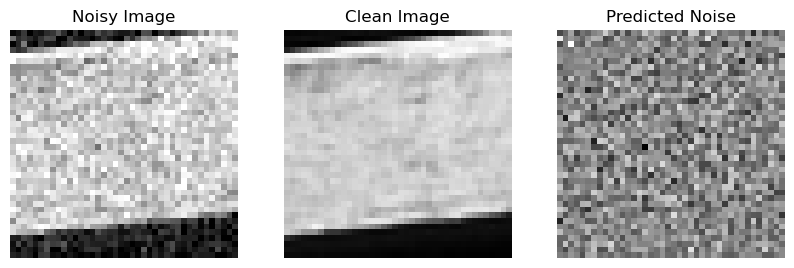

Batch 10/2500   | Loss: 0.001448
Batch 20/2500   | Loss: 0.001629
Batch 30/2500   | Loss: 0.001507
Batch 40/2500   | Loss: 0.001470
Batch 50/2500   | Loss: 0.001526
Batch 60/2500   | Loss: 0.001605
Batch 70/2500   | Loss: 0.001657
Batch 80/2500   | Loss: 0.001712
Batch 90/2500   | Loss: 0.001506
Batch 100/2500   | Loss: 0.001528
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_18_batch_100.pth
Batch 110/2500   | Loss: 0.001799
Batch 120/2500   | Loss: 0.001664
Batch 130/2500   | Loss: 0.001627
Batch 140/2500   | Loss: 0.001505
Batch 150/2500   | Loss: 0.001583
Batch 160/2500   | Loss: 0.001520
Batch 170/2500   | Loss: 0.001612
Batch 180/2500   | Loss: 0.001603
Batch 190/2500   | Loss: 0.001604
Batch 200/2500   | Loss: 0.001706
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_18_batch_200.pth
Batch 210/250

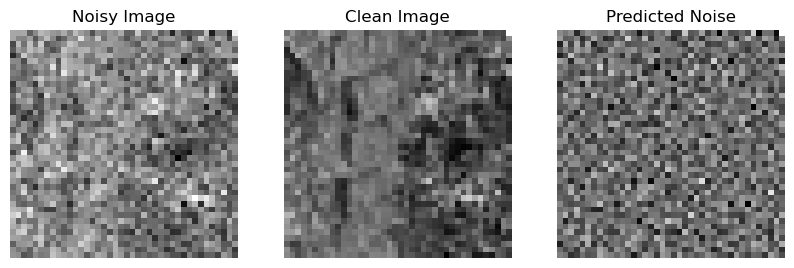

Batch 510/2500   | Loss: 0.001572
Batch 520/2500   | Loss: 0.001665
Batch 530/2500   | Loss: 0.001749
Batch 540/2500   | Loss: 0.001550
Batch 550/2500   | Loss: 0.001608
Batch 560/2500   | Loss: 0.001678
Batch 570/2500   | Loss: 0.001655
Batch 580/2500   | Loss: 0.001576
Batch 590/2500   | Loss: 0.001659
Batch 600/2500   | Loss: 0.001754
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_18_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_18_batch_300.pth
Batch 610/2500   | Loss: 0.001530
Batch 620/2500   | Loss: 0.001822
Batch 630/2500   | Loss: 0.001769
Batch 640/2500   | Loss: 0.001586
Batch 650/2500   | Loss: 0.001531
Batch 660/2500   | Loss: 0.001449
Batch 670/2500   | Loss: 0.001525
Batch 680/2500   | Loss: 0.001607
Batch 690/2500   | Loss: 0.001701
Batch 700/2500   | Loss: 0.00158

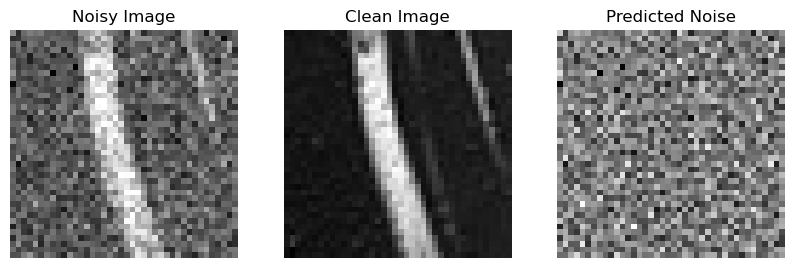

Batch 1010/2500   | Loss: 0.001546
Batch 1020/2500   | Loss: 0.001687
Batch 1030/2500   | Loss: 0.001606
Batch 1040/2500   | Loss: 0.001473
Batch 1050/2500   | Loss: 0.001580
Batch 1060/2500   | Loss: 0.001711
Batch 1070/2500   | Loss: 0.001536
Batch 1080/2500   | Loss: 0.001571
Batch 1090/2500   | Loss: 0.001657
Batch 1100/2500   | Loss: 0.001652
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_18_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_18_batch_800.pth
Batch 1110/2500   | Loss: 0.001543
Batch 1120/2500   | Loss: 0.001608
Batch 1130/2500   | Loss: 0.001642
Batch 1140/2500   | Loss: 0.001594
Batch 1150/2500   | Loss: 0.001653
Batch 1160/2500   | Loss: 0.001653
Batch 1170/2500   | Loss: 0.001497
Batch 1180/2500   | Loss: 0.001637
Batch 1190/2500   | Loss: 0.001385
Batch 1200/2

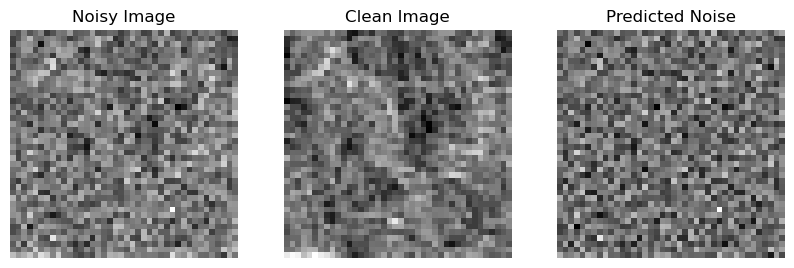

Batch 1510/2500   | Loss: 0.001677
Batch 1520/2500   | Loss: 0.001701
Batch 1530/2500   | Loss: 0.001766
Batch 1540/2500   | Loss: 0.001603
Batch 1550/2500   | Loss: 0.001574
Batch 1560/2500   | Loss: 0.001669
Batch 1570/2500   | Loss: 0.001592
Batch 1580/2500   | Loss: 0.001704
Batch 1590/2500   | Loss: 0.001661
Batch 1600/2500   | Loss: 0.001644
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_18_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_18_batch_1300.pth
Batch 1610/2500   | Loss: 0.001708
Batch 1620/2500   | Loss: 0.001785
Batch 1630/2500   | Loss: 0.001769
Batch 1640/2500   | Loss: 0.001871
Batch 1650/2500   | Loss: 0.001600
Batch 1660/2500   | Loss: 0.001688
Batch 1670/2500   | Loss: 0.001942
Batch 1680/2500   | Loss: 0.001724
Batch 1690/2500   | Loss: 0.001561
Batch 1700/

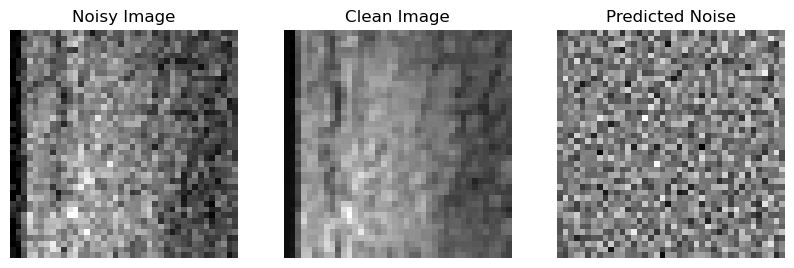

Batch 2010/2500   | Loss: 0.001570
Batch 2020/2500   | Loss: 0.001571
Batch 2030/2500   | Loss: 0.001531
Batch 2040/2500   | Loss: 0.001808
Batch 2050/2500   | Loss: 0.001689
Batch 2060/2500   | Loss: 0.001739
Batch 2070/2500   | Loss: 0.001553
Batch 2080/2500   | Loss: 0.001501
Batch 2090/2500   | Loss: 0.001536
Batch 2100/2500   | Loss: 0.001667
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_18_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_18_batch_1800.pth
Batch 2110/2500   | Loss: 0.001580
Batch 2120/2500   | Loss: 0.001644
Batch 2130/2500   | Loss: 0.001628
Batch 2140/2500   | Loss: 0.001463
Batch 2150/2500   | Loss: 0.001659
Batch 2160/2500   | Loss: 0.001499
Batch 2170/2500   | Loss: 0.001607
Batch 2180/2500   | Loss: 0.001772
Batch 2190/2500   | Loss: 0.001635
Batch 2200/

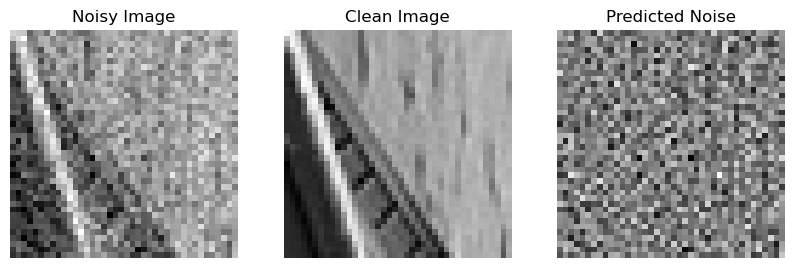

Batch 10/2500   | Loss: 0.001644
Batch 20/2500   | Loss: 0.001668
Batch 30/2500   | Loss: 0.001364
Batch 40/2500   | Loss: 0.001738
Batch 50/2500   | Loss: 0.001712
Batch 60/2500   | Loss: 0.001656
Batch 70/2500   | Loss: 0.001611
Batch 80/2500   | Loss: 0.001600
Batch 90/2500   | Loss: 0.001563
Batch 100/2500   | Loss: 0.001720
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_19_batch_100.pth
Batch 110/2500   | Loss: 0.001522
Batch 120/2500   | Loss: 0.001603
Batch 130/2500   | Loss: 0.001631
Batch 140/2500   | Loss: 0.001785
Batch 150/2500   | Loss: 0.001518
Batch 160/2500   | Loss: 0.001674
Batch 170/2500   | Loss: 0.001460
Batch 180/2500   | Loss: 0.001576
Batch 190/2500   | Loss: 0.001582
Batch 200/2500   | Loss: 0.001583
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_19_batch_200.pth
Batch 210/250

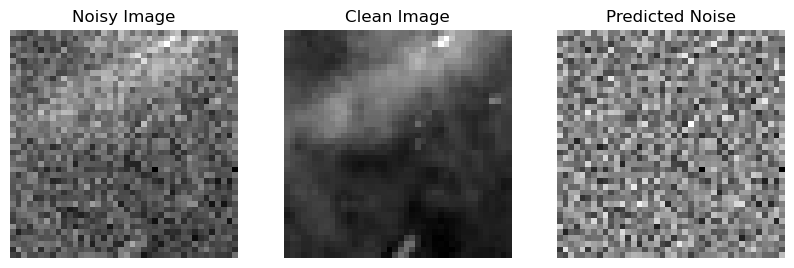

Batch 510/2500   | Loss: 0.001614
Batch 520/2500   | Loss: 0.001521
Batch 530/2500   | Loss: 0.001466
Batch 540/2500   | Loss: 0.001450
Batch 550/2500   | Loss: 0.001666
Batch 560/2500   | Loss: 0.001439
Batch 570/2500   | Loss: 0.001732
Batch 580/2500   | Loss: 0.001792
Batch 590/2500   | Loss: 0.001607
Batch 600/2500   | Loss: 0.001601
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_19_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_19_batch_300.pth
Batch 610/2500   | Loss: 0.001676
Batch 620/2500   | Loss: 0.001718
Batch 630/2500   | Loss: 0.001538
Batch 640/2500   | Loss: 0.001728
Batch 650/2500   | Loss: 0.001637
Batch 660/2500   | Loss: 0.001635
Batch 670/2500   | Loss: 0.001624
Batch 680/2500   | Loss: 0.001717
Batch 690/2500   | Loss: 0.001558
Batch 700/2500   | Loss: 0.00150

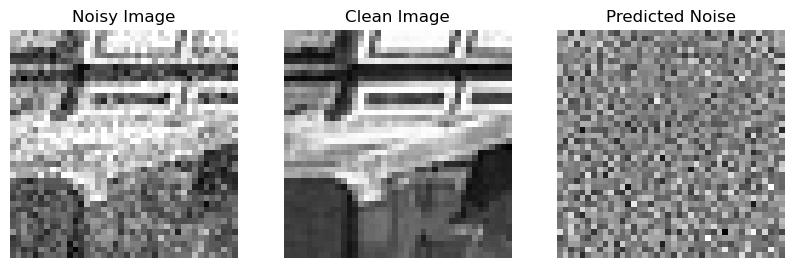

Batch 1010/2500   | Loss: 0.001537
Batch 1020/2500   | Loss: 0.001573
Batch 1030/2500   | Loss: 0.001491
Batch 1040/2500   | Loss: 0.001565
Batch 1050/2500   | Loss: 0.001580
Batch 1060/2500   | Loss: 0.001747
Batch 1070/2500   | Loss: 0.001478
Batch 1080/2500   | Loss: 0.001703
Batch 1090/2500   | Loss: 0.001620
Batch 1100/2500   | Loss: 0.001536
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_19_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_19_batch_800.pth
Batch 1110/2500   | Loss: 0.001617
Batch 1120/2500   | Loss: 0.001715
Batch 1130/2500   | Loss: 0.001790
Batch 1140/2500   | Loss: 0.001579
Batch 1150/2500   | Loss: 0.001594
Batch 1160/2500   | Loss: 0.001645
Batch 1170/2500   | Loss: 0.001782
Batch 1180/2500   | Loss: 0.001795
Batch 1190/2500   | Loss: 0.001518
Batch 1200/2

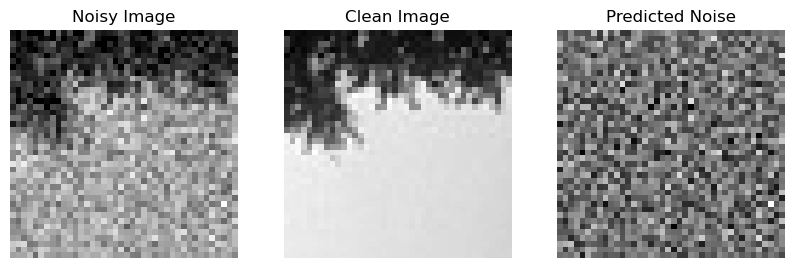

Batch 1510/2500   | Loss: 0.001602
Batch 1520/2500   | Loss: 0.001596
Batch 1530/2500   | Loss: 0.001578
Batch 1540/2500   | Loss: 0.001445
Batch 1550/2500   | Loss: 0.001608
Batch 1560/2500   | Loss: 0.001717
Batch 1570/2500   | Loss: 0.001551
Batch 1580/2500   | Loss: 0.001637
Batch 1590/2500   | Loss: 0.001598
Batch 1600/2500   | Loss: 0.001683
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_19_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_19_batch_1300.pth
Batch 1610/2500   | Loss: 0.001616
Batch 1620/2500   | Loss: 0.001550
Batch 1630/2500   | Loss: 0.001742
Batch 1640/2500   | Loss: 0.001493
Batch 1650/2500   | Loss: 0.001456
Batch 1660/2500   | Loss: 0.001627
Batch 1670/2500   | Loss: 0.001546
Batch 1680/2500   | Loss: 0.001463
Batch 1690/2500   | Loss: 0.001625
Batch 1700/

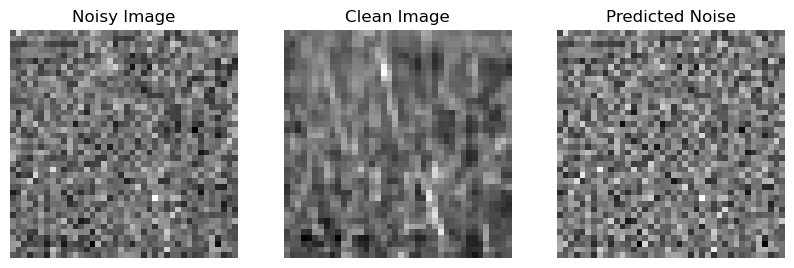

Batch 2010/2500   | Loss: 0.001427
Batch 2020/2500   | Loss: 0.001557
Batch 2030/2500   | Loss: 0.001605
Batch 2040/2500   | Loss: 0.001410
Batch 2050/2500   | Loss: 0.001711
Batch 2060/2500   | Loss: 0.001719
Batch 2070/2500   | Loss: 0.001760
Batch 2080/2500   | Loss: 0.001436
Batch 2090/2500   | Loss: 0.001467
Batch 2100/2500   | Loss: 0.001641
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_19_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_19_batch_1800.pth
Batch 2110/2500   | Loss: 0.001702
Batch 2120/2500   | Loss: 0.001582
Batch 2130/2500   | Loss: 0.001784
Batch 2140/2500   | Loss: 0.001416
Batch 2150/2500   | Loss: 0.001660
Batch 2160/2500   | Loss: 0.001682
Batch 2170/2500   | Loss: 0.001546
Batch 2180/2500   | Loss: 0.001726
Batch 2190/2500   | Loss: 0.001618
Batch 2200/

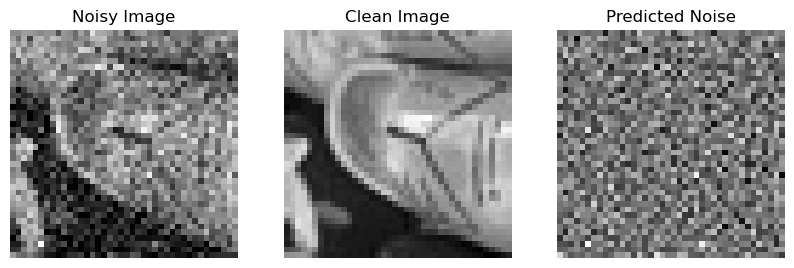

Batch 10/2500   | Loss: 0.001653
Batch 20/2500   | Loss: 0.001438
Batch 30/2500   | Loss: 0.001539
Batch 40/2500   | Loss: 0.001582
Batch 50/2500   | Loss: 0.001571
Batch 60/2500   | Loss: 0.001647
Batch 70/2500   | Loss: 0.001752
Batch 80/2500   | Loss: 0.001619
Batch 90/2500   | Loss: 0.001762
Batch 100/2500   | Loss: 0.001544
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_20_batch_100.pth
Batch 110/2500   | Loss: 0.001584
Batch 120/2500   | Loss: 0.001509
Batch 130/2500   | Loss: 0.001586
Batch 140/2500   | Loss: 0.001642
Batch 150/2500   | Loss: 0.001848
Batch 160/2500   | Loss: 0.001632
Batch 170/2500   | Loss: 0.001486
Batch 180/2500   | Loss: 0.001683
Batch 190/2500   | Loss: 0.001404
Batch 200/2500   | Loss: 0.001580
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_20_batch_200.pth
Batch 210/250

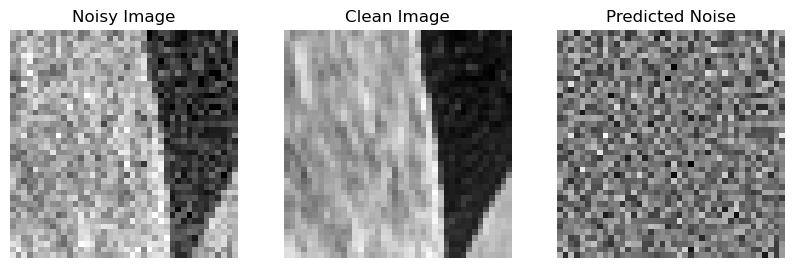

Batch 510/2500   | Loss: 0.001723
Batch 520/2500   | Loss: 0.001543
Batch 530/2500   | Loss: 0.001704
Batch 540/2500   | Loss: 0.001634
Batch 550/2500   | Loss: 0.001769
Batch 560/2500   | Loss: 0.001538
Batch 570/2500   | Loss: 0.001577
Batch 580/2500   | Loss: 0.001433
Batch 590/2500   | Loss: 0.001664
Batch 600/2500   | Loss: 0.001845
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_20_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_20_batch_300.pth
Batch 610/2500   | Loss: 0.001699
Batch 620/2500   | Loss: 0.001808
Batch 630/2500   | Loss: 0.001721
Batch 640/2500   | Loss: 0.001599
Batch 650/2500   | Loss: 0.001708
Batch 660/2500   | Loss: 0.001581
Batch 670/2500   | Loss: 0.001367
Batch 680/2500   | Loss: 0.001514
Batch 690/2500   | Loss: 0.001773
Batch 700/2500   | Loss: 0.00157

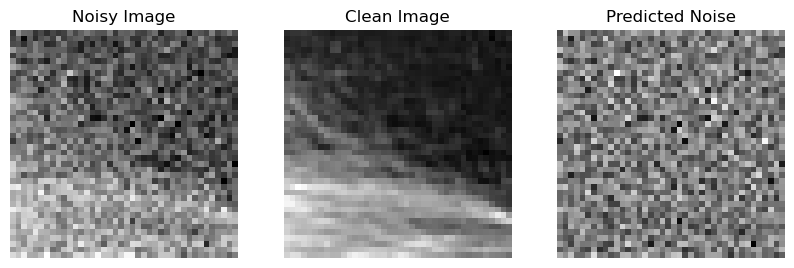

Batch 1010/2500   | Loss: 0.001637
Batch 1020/2500   | Loss: 0.001745
Batch 1030/2500   | Loss: 0.001629
Batch 1040/2500   | Loss: 0.001582
Batch 1050/2500   | Loss: 0.001684
Batch 1060/2500   | Loss: 0.001773
Batch 1070/2500   | Loss: 0.001549
Batch 1080/2500   | Loss: 0.001728
Batch 1090/2500   | Loss: 0.001902
Batch 1100/2500   | Loss: 0.001587
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_20_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_20_batch_800.pth
Batch 1110/2500   | Loss: 0.001618
Batch 1120/2500   | Loss: 0.001612
Batch 1130/2500   | Loss: 0.001636
Batch 1140/2500   | Loss: 0.001761
Batch 1150/2500   | Loss: 0.001659
Batch 1160/2500   | Loss: 0.001711
Batch 1170/2500   | Loss: 0.001495
Batch 1180/2500   | Loss: 0.001568
Batch 1190/2500   | Loss: 0.001656
Batch 1200/2

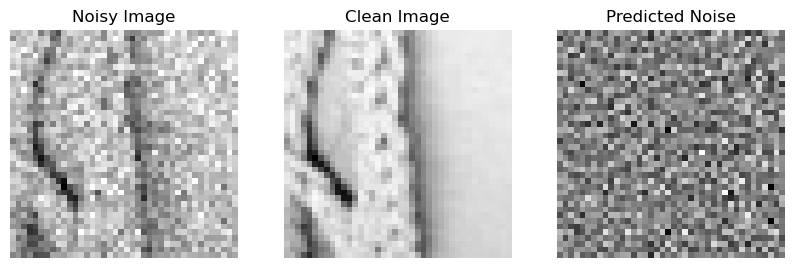

Batch 1510/2500   | Loss: 0.001437
Batch 1520/2500   | Loss: 0.001733
Batch 1530/2500   | Loss: 0.001663
Batch 1540/2500   | Loss: 0.001753
Batch 1550/2500   | Loss: 0.001723
Batch 1560/2500   | Loss: 0.001631
Batch 1570/2500   | Loss: 0.001739
Batch 1580/2500   | Loss: 0.001717
Batch 1590/2500   | Loss: 0.001494
Batch 1600/2500   | Loss: 0.001500
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_20_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_20_batch_1300.pth
Batch 1610/2500   | Loss: 0.001580
Batch 1620/2500   | Loss: 0.001602
Batch 1630/2500   | Loss: 0.001518
Batch 1640/2500   | Loss: 0.001548
Batch 1650/2500   | Loss: 0.001518
Batch 1660/2500   | Loss: 0.001515
Batch 1670/2500   | Loss: 0.001466
Batch 1680/2500   | Loss: 0.001838
Batch 1690/2500   | Loss: 0.001610
Batch 1700/

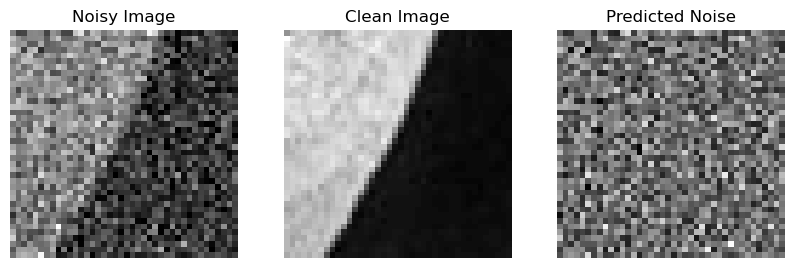

Batch 2010/2500   | Loss: 0.001578
Batch 2020/2500   | Loss: 0.001567
Batch 2030/2500   | Loss: 0.001588
Batch 2040/2500   | Loss: 0.001577
Batch 2050/2500   | Loss: 0.001583
Batch 2060/2500   | Loss: 0.001452
Batch 2070/2500   | Loss: 0.001508
Batch 2080/2500   | Loss: 0.001601
Batch 2090/2500   | Loss: 0.001712
Batch 2100/2500   | Loss: 0.001560
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_20_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_20_batch_1800.pth
Batch 2110/2500   | Loss: 0.001832
Batch 2120/2500   | Loss: 0.001645
Batch 2130/2500   | Loss: 0.001603
Batch 2140/2500   | Loss: 0.001713
Batch 2150/2500   | Loss: 0.001519
Batch 2160/2500   | Loss: 0.001590
Batch 2170/2500   | Loss: 0.001574
Batch 2180/2500   | Loss: 0.001493
Batch 2190/2500   | Loss: 0.001560
Batch 2200/

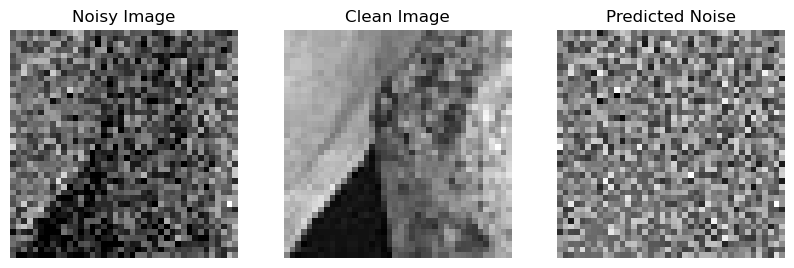

Batch 10/2500   | Loss: 0.001499
Batch 20/2500   | Loss: 0.001897
Batch 30/2500   | Loss: 0.001459
Batch 40/2500   | Loss: 0.001510
Batch 50/2500   | Loss: 0.001690
Batch 60/2500   | Loss: 0.001641
Batch 70/2500   | Loss: 0.001499
Batch 80/2500   | Loss: 0.001740
Batch 90/2500   | Loss: 0.001539
Batch 100/2500   | Loss: 0.001528
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_21_batch_100.pth
Batch 110/2500   | Loss: 0.001736
Batch 120/2500   | Loss: 0.001785
Batch 130/2500   | Loss: 0.001652
Batch 140/2500   | Loss: 0.001511
Batch 150/2500   | Loss: 0.001595
Batch 160/2500   | Loss: 0.001580
Batch 170/2500   | Loss: 0.001670
Batch 180/2500   | Loss: 0.001656
Batch 190/2500   | Loss: 0.001571
Batch 200/2500   | Loss: 0.001493
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_21_batch_200.pth
Batch 210/250

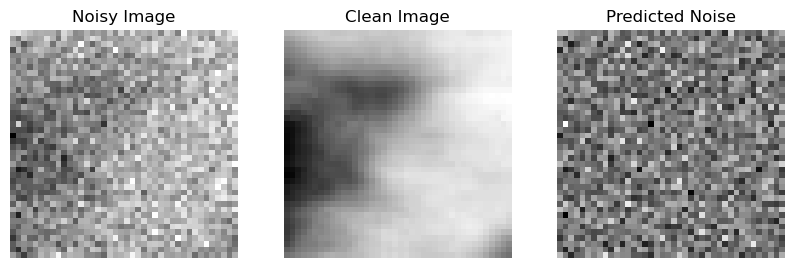

Batch 510/2500   | Loss: 0.001487
Batch 520/2500   | Loss: 0.001899
Batch 530/2500   | Loss: 0.001540
Batch 540/2500   | Loss: 0.001758
Batch 550/2500   | Loss: 0.001474
Batch 560/2500   | Loss: 0.001659
Batch 570/2500   | Loss: 0.001667
Batch 580/2500   | Loss: 0.001488
Batch 590/2500   | Loss: 0.001893
Batch 600/2500   | Loss: 0.001632
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_21_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_21_batch_300.pth
Batch 610/2500   | Loss: 0.001448
Batch 620/2500   | Loss: 0.001606
Batch 630/2500   | Loss: 0.001559
Batch 640/2500   | Loss: 0.001589
Batch 650/2500   | Loss: 0.001638
Batch 660/2500   | Loss: 0.001534
Batch 670/2500   | Loss: 0.001583
Batch 680/2500   | Loss: 0.001629
Batch 690/2500   | Loss: 0.001484
Batch 700/2500   | Loss: 0.00154

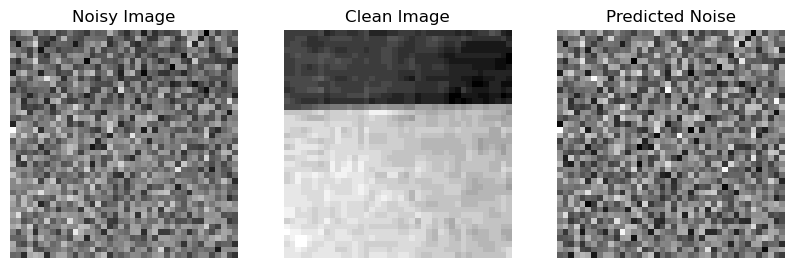

Batch 1010/2500   | Loss: 0.001741
Batch 1020/2500   | Loss: 0.001774
Batch 1030/2500   | Loss: 0.001556
Batch 1040/2500   | Loss: 0.001739
Batch 1050/2500   | Loss: 0.001880
Batch 1060/2500   | Loss: 0.001649
Batch 1070/2500   | Loss: 0.001566
Batch 1080/2500   | Loss: 0.001643
Batch 1090/2500   | Loss: 0.001559
Batch 1100/2500   | Loss: 0.001654
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_21_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_21_batch_800.pth
Batch 1110/2500   | Loss: 0.001367
Batch 1120/2500   | Loss: 0.001560
Batch 1130/2500   | Loss: 0.001625
Batch 1140/2500   | Loss: 0.001622
Batch 1150/2500   | Loss: 0.001441
Batch 1160/2500   | Loss: 0.001693
Batch 1170/2500   | Loss: 0.001503
Batch 1180/2500   | Loss: 0.001638
Batch 1190/2500   | Loss: 0.001652
Batch 1200/2

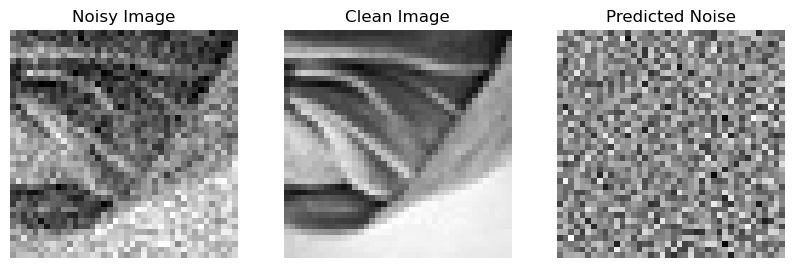

Batch 1510/2500   | Loss: 0.001453
Batch 1520/2500   | Loss: 0.002089
Batch 1530/2500   | Loss: 0.001436
Batch 1540/2500   | Loss: 0.001575
Batch 1550/2500   | Loss: 0.001534
Batch 1560/2500   | Loss: 0.001559
Batch 1570/2500   | Loss: 0.001459
Batch 1580/2500   | Loss: 0.001441
Batch 1590/2500   | Loss: 0.002120
Batch 1600/2500   | Loss: 0.001614
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_21_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_21_batch_1300.pth
Batch 1610/2500   | Loss: 0.001592
Batch 1620/2500   | Loss: 0.001669
Batch 1630/2500   | Loss: 0.001560
Batch 1640/2500   | Loss: 0.001540
Batch 1650/2500   | Loss: 0.001430
Batch 1660/2500   | Loss: 0.001511
Batch 1670/2500   | Loss: 0.001458
Batch 1680/2500   | Loss: 0.001667
Batch 1690/2500   | Loss: 0.001626
Batch 1700/

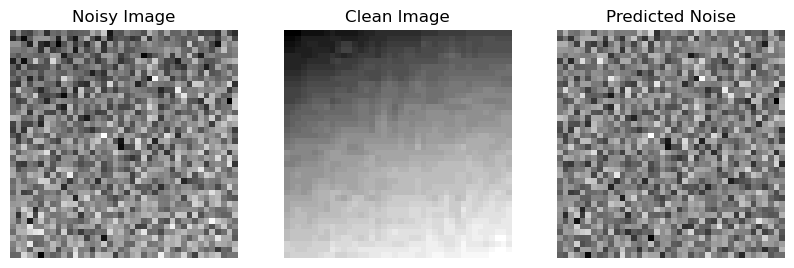

Batch 2010/2500   | Loss: 0.001630
Batch 2020/2500   | Loss: 0.001563
Batch 2030/2500   | Loss: 0.001581
Batch 2040/2500   | Loss: 0.001633
Batch 2050/2500   | Loss: 0.001529
Batch 2060/2500   | Loss: 0.001595
Batch 2070/2500   | Loss: 0.001599
Batch 2080/2500   | Loss: 0.001649
Batch 2090/2500   | Loss: 0.001707
Batch 2100/2500   | Loss: 0.001520
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_21_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_21_batch_1800.pth
Batch 2110/2500   | Loss: 0.001527
Batch 2120/2500   | Loss: 0.001779
Batch 2130/2500   | Loss: 0.001665
Batch 2140/2500   | Loss: 0.001563
Batch 2150/2500   | Loss: 0.001657
Batch 2160/2500   | Loss: 0.001485
Batch 2170/2500   | Loss: 0.001637
Batch 2180/2500   | Loss: 0.001616
Batch 2190/2500   | Loss: 0.001651
Batch 2200/

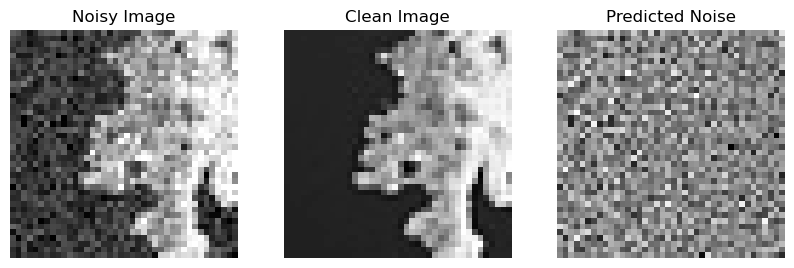

Batch 10/2500   | Loss: 0.001825
Batch 20/2500   | Loss: 0.001723
Batch 30/2500   | Loss: 0.001645
Batch 40/2500   | Loss: 0.001882
Batch 50/2500   | Loss: 0.001489
Batch 60/2500   | Loss: 0.001405
Batch 70/2500   | Loss: 0.001530
Batch 80/2500   | Loss: 0.001494
Batch 90/2500   | Loss: 0.001631
Batch 100/2500   | Loss: 0.001518
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_22_batch_100.pth
Batch 110/2500   | Loss: 0.001818
Batch 120/2500   | Loss: 0.001602
Batch 130/2500   | Loss: 0.001636
Batch 140/2500   | Loss: 0.001612
Batch 150/2500   | Loss: 0.001607
Batch 160/2500   | Loss: 0.001528
Batch 170/2500   | Loss: 0.001607
Batch 180/2500   | Loss: 0.001772
Batch 190/2500   | Loss: 0.001945
Batch 200/2500   | Loss: 0.001866
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_22_batch_200.pth
Batch 210/250

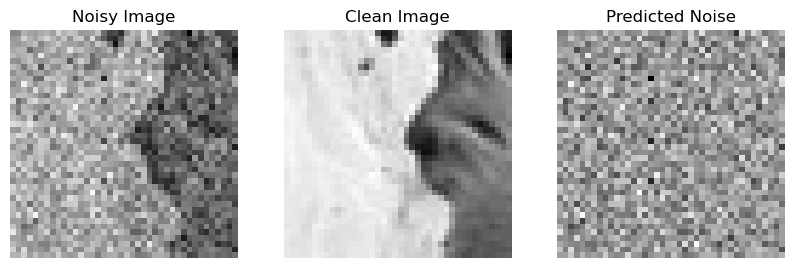

Batch 510/2500   | Loss: 0.001421
Batch 520/2500   | Loss: 0.001713
Batch 530/2500   | Loss: 0.001573
Batch 540/2500   | Loss: 0.001554
Batch 550/2500   | Loss: 0.001637
Batch 560/2500   | Loss: 0.001547
Batch 570/2500   | Loss: 0.001684
Batch 580/2500   | Loss: 0.001314
Batch 590/2500   | Loss: 0.001526
Batch 600/2500   | Loss: 0.001759
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_22_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_22_batch_300.pth
Batch 610/2500   | Loss: 0.001714
Batch 620/2500   | Loss: 0.001606
Batch 630/2500   | Loss: 0.001625
Batch 640/2500   | Loss: 0.001739
Batch 650/2500   | Loss: 0.001438
Batch 660/2500   | Loss: 0.001641
Batch 670/2500   | Loss: 0.001522
Batch 680/2500   | Loss: 0.001775
Batch 690/2500   | Loss: 0.001677
Batch 700/2500   | Loss: 0.00168

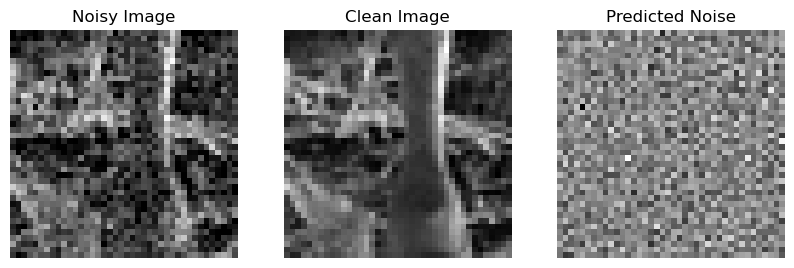

Batch 1010/2500   | Loss: 0.001542
Batch 1020/2500   | Loss: 0.001485
Batch 1030/2500   | Loss: 0.001633
Batch 1040/2500   | Loss: 0.001698
Batch 1050/2500   | Loss: 0.001485
Batch 1060/2500   | Loss: 0.001590
Batch 1070/2500   | Loss: 0.001688
Batch 1080/2500   | Loss: 0.001683
Batch 1090/2500   | Loss: 0.001515
Batch 1100/2500   | Loss: 0.001735
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_22_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_22_batch_800.pth
Batch 1110/2500   | Loss: 0.001686
Batch 1120/2500   | Loss: 0.001562
Batch 1130/2500   | Loss: 0.001707
Batch 1140/2500   | Loss: 0.001522
Batch 1150/2500   | Loss: 0.001573
Batch 1160/2500   | Loss: 0.001440
Batch 1170/2500   | Loss: 0.001657
Batch 1180/2500   | Loss: 0.001588
Batch 1190/2500   | Loss: 0.001854
Batch 1200/2

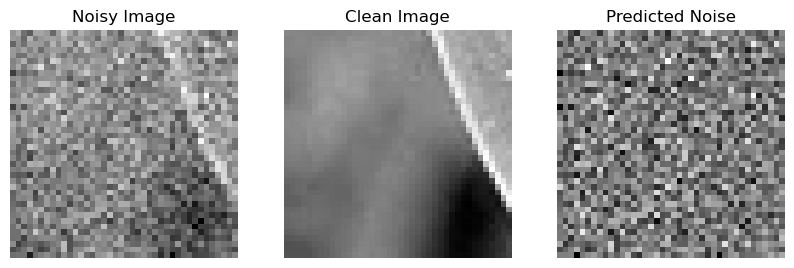

Batch 1510/2500   | Loss: 0.001500
Batch 1520/2500   | Loss: 0.001489
Batch 1530/2500   | Loss: 0.001520
Batch 1540/2500   | Loss: 0.001638
Batch 1550/2500   | Loss: 0.001689
Batch 1560/2500   | Loss: 0.001755
Batch 1570/2500   | Loss: 0.001453
Batch 1580/2500   | Loss: 0.001701
Batch 1590/2500   | Loss: 0.001452
Batch 1600/2500   | Loss: 0.001632
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_22_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_22_batch_1300.pth
Batch 1610/2500   | Loss: 0.001740
Batch 1620/2500   | Loss: 0.001641
Batch 1630/2500   | Loss: 0.001694
Batch 1640/2500   | Loss: 0.001564
Batch 1650/2500   | Loss: 0.001577
Batch 1660/2500   | Loss: 0.001533
Batch 1670/2500   | Loss: 0.001607
Batch 1680/2500   | Loss: 0.001628
Batch 1690/2500   | Loss: 0.001486
Batch 1700/

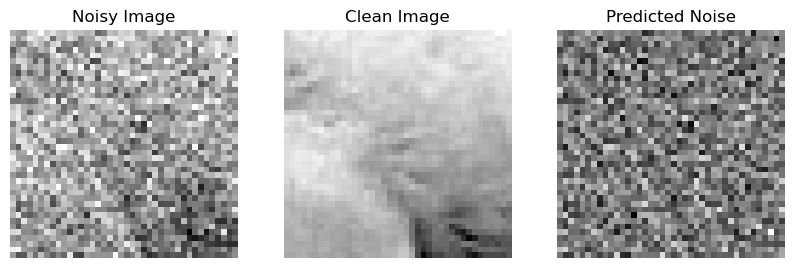

Batch 2010/2500   | Loss: 0.001568
Batch 2020/2500   | Loss: 0.001512
Batch 2030/2500   | Loss: 0.001683
Batch 2040/2500   | Loss: 0.001497
Batch 2050/2500   | Loss: 0.001788
Batch 2060/2500   | Loss: 0.001723
Batch 2070/2500   | Loss: 0.001389
Batch 2080/2500   | Loss: 0.001477
Batch 2090/2500   | Loss: 0.001723
Batch 2100/2500   | Loss: 0.001552
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_22_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_22_batch_1800.pth
Batch 2110/2500   | Loss: 0.001555
Batch 2120/2500   | Loss: 0.001513
Batch 2130/2500   | Loss: 0.001689
Batch 2140/2500   | Loss: 0.001707
Batch 2150/2500   | Loss: 0.001770
Batch 2160/2500   | Loss: 0.001464
Batch 2170/2500   | Loss: 0.001558
Batch 2180/2500   | Loss: 0.001437
Batch 2190/2500   | Loss: 0.001401
Batch 2200/

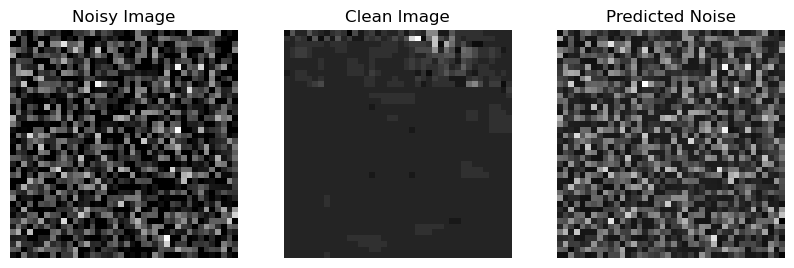

Batch 10/2500   | Loss: 0.001564
Batch 20/2500   | Loss: 0.001489
Batch 30/2500   | Loss: 0.001490
Batch 40/2500   | Loss: 0.001711
Batch 50/2500   | Loss: 0.001624
Batch 60/2500   | Loss: 0.001701
Batch 70/2500   | Loss: 0.001785
Batch 80/2500   | Loss: 0.001618
Batch 90/2500   | Loss: 0.001618
Batch 100/2500   | Loss: 0.001629
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_23_batch_100.pth
Batch 110/2500   | Loss: 0.001542
Batch 120/2500   | Loss: 0.001654
Batch 130/2500   | Loss: 0.001782
Batch 140/2500   | Loss: 0.001592
Batch 150/2500   | Loss: 0.001522
Batch 160/2500   | Loss: 0.001411
Batch 170/2500   | Loss: 0.001657
Batch 180/2500   | Loss: 0.001690
Batch 190/2500   | Loss: 0.001658
Batch 200/2500   | Loss: 0.001726
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_23_batch_200.pth
Batch 210/250

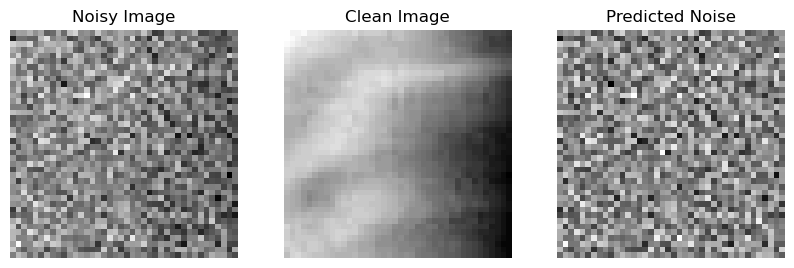

Batch 510/2500   | Loss: 0.001666
Batch 520/2500   | Loss: 0.001599
Batch 530/2500   | Loss: 0.001710
Batch 540/2500   | Loss: 0.001556
Batch 550/2500   | Loss: 0.001676
Batch 560/2500   | Loss: 0.001627
Batch 570/2500   | Loss: 0.001559
Batch 580/2500   | Loss: 0.001661
Batch 590/2500   | Loss: 0.001632
Batch 600/2500   | Loss: 0.001490
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_23_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_23_batch_300.pth
Batch 610/2500   | Loss: 0.001627
Batch 620/2500   | Loss: 0.001775
Batch 630/2500   | Loss: 0.001576
Batch 640/2500   | Loss: 0.001549
Batch 650/2500   | Loss: 0.001642
Batch 660/2500   | Loss: 0.001589
Batch 670/2500   | Loss: 0.001554
Batch 680/2500   | Loss: 0.001502
Batch 690/2500   | Loss: 0.001671
Batch 700/2500   | Loss: 0.00159

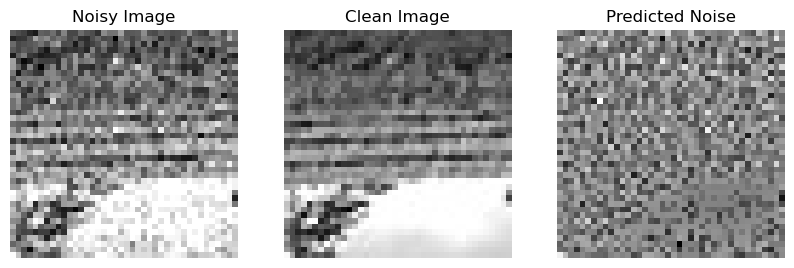

Batch 1010/2500   | Loss: 0.001533
Batch 1020/2500   | Loss: 0.001549
Batch 1030/2500   | Loss: 0.001504
Batch 1040/2500   | Loss: 0.001604
Batch 1050/2500   | Loss: 0.001729
Batch 1060/2500   | Loss: 0.001468
Batch 1070/2500   | Loss: 0.001621
Batch 1080/2500   | Loss: 0.001654
Batch 1090/2500   | Loss: 0.001450
Batch 1100/2500   | Loss: 0.001604
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_23_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_23_batch_800.pth
Batch 1110/2500   | Loss: 0.001738
Batch 1120/2500   | Loss: 0.001593
Batch 1130/2500   | Loss: 0.001685
Batch 1140/2500   | Loss: 0.001670
Batch 1150/2500   | Loss: 0.001683
Batch 1160/2500   | Loss: 0.001587
Batch 1170/2500   | Loss: 0.001660
Batch 1180/2500   | Loss: 0.001597
Batch 1190/2500   | Loss: 0.001517
Batch 1200/2

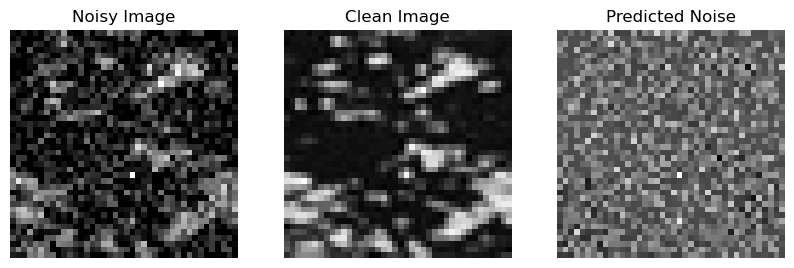

Batch 1510/2500   | Loss: 0.001531
Batch 1520/2500   | Loss: 0.001494
Batch 1530/2500   | Loss: 0.001559
Batch 1540/2500   | Loss: 0.001697
Batch 1550/2500   | Loss: 0.001633
Batch 1560/2500   | Loss: 0.001673
Batch 1570/2500   | Loss: 0.001534
Batch 1580/2500   | Loss: 0.001788
Batch 1590/2500   | Loss: 0.001759
Batch 1600/2500   | Loss: 0.001589
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_23_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_23_batch_1300.pth
Batch 1610/2500   | Loss: 0.001460
Batch 1620/2500   | Loss: 0.001673
Batch 1630/2500   | Loss: 0.001569
Batch 1640/2500   | Loss: 0.001687
Batch 1650/2500   | Loss: 0.001633
Batch 1660/2500   | Loss: 0.001632
Batch 1670/2500   | Loss: 0.001533
Batch 1680/2500   | Loss: 0.001498
Batch 1690/2500   | Loss: 0.001757
Batch 1700/

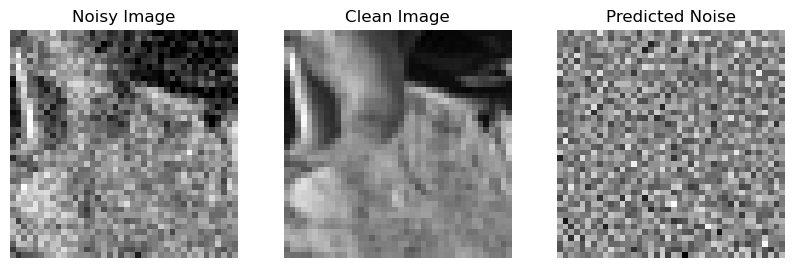

Batch 2010/2500   | Loss: 0.001436
Batch 2020/2500   | Loss: 0.001470
Batch 2030/2500   | Loss: 0.001430
Batch 2040/2500   | Loss: 0.001643
Batch 2050/2500   | Loss: 0.001681
Batch 2060/2500   | Loss: 0.001553
Batch 2070/2500   | Loss: 0.001725
Batch 2080/2500   | Loss: 0.001645
Batch 2090/2500   | Loss: 0.001527
Batch 2100/2500   | Loss: 0.001711
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_23_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_23_batch_1800.pth
Batch 2110/2500   | Loss: 0.001569
Batch 2120/2500   | Loss: 0.001494
Batch 2130/2500   | Loss: 0.001641
Batch 2140/2500   | Loss: 0.001678
Batch 2150/2500   | Loss: 0.001686
Batch 2160/2500   | Loss: 0.001495
Batch 2170/2500   | Loss: 0.001711
Batch 2180/2500   | Loss: 0.001596
Batch 2190/2500   | Loss: 0.001741
Batch 2200/

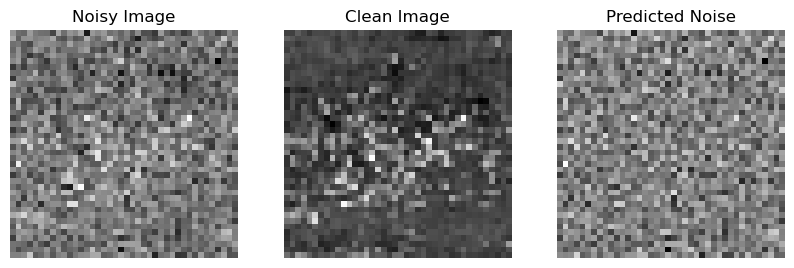

Batch 10/2500   | Loss: 0.001705
Batch 20/2500   | Loss: 0.001842
Batch 30/2500   | Loss: 0.001546
Batch 40/2500   | Loss: 0.001441
Batch 50/2500   | Loss: 0.001564
Batch 60/2500   | Loss: 0.001649
Batch 70/2500   | Loss: 0.001477
Batch 80/2500   | Loss: 0.001728
Batch 90/2500   | Loss: 0.001594
Batch 100/2500   | Loss: 0.001551
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_24_batch_100.pth
Batch 110/2500   | Loss: 0.001714
Batch 120/2500   | Loss: 0.001439
Batch 130/2500   | Loss: 0.001597
Batch 140/2500   | Loss: 0.001549
Batch 150/2500   | Loss: 0.001420
Batch 160/2500   | Loss: 0.001467
Batch 170/2500   | Loss: 0.001445
Batch 180/2500   | Loss: 0.001536
Batch 190/2500   | Loss: 0.001576
Batch 200/2500   | Loss: 0.001650
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_24_batch_200.pth
Batch 210/250

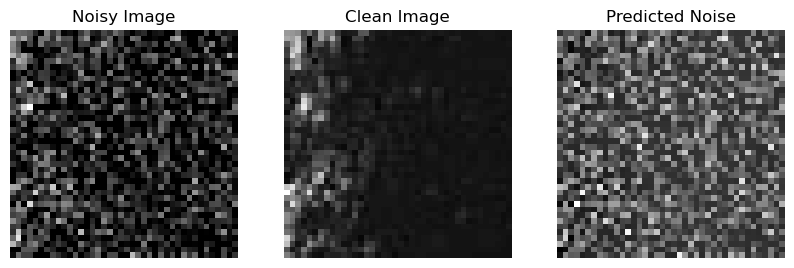

Batch 510/2500   | Loss: 0.001579
Batch 520/2500   | Loss: 0.001715
Batch 530/2500   | Loss: 0.001566
Batch 540/2500   | Loss: 0.001563
Batch 550/2500   | Loss: 0.001837
Batch 560/2500   | Loss: 0.001573
Batch 570/2500   | Loss: 0.001558
Batch 580/2500   | Loss: 0.001554
Batch 590/2500   | Loss: 0.001633
Batch 600/2500   | Loss: 0.001655
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_24_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_24_batch_300.pth
Batch 610/2500   | Loss: 0.001652
Batch 620/2500   | Loss: 0.001556
Batch 630/2500   | Loss: 0.001483
Batch 640/2500   | Loss: 0.001641
Batch 650/2500   | Loss: 0.001633
Batch 660/2500   | Loss: 0.001744
Batch 670/2500   | Loss: 0.001454
Batch 680/2500   | Loss: 0.001605
Batch 690/2500   | Loss: 0.001760
Batch 700/2500   | Loss: 0.00146

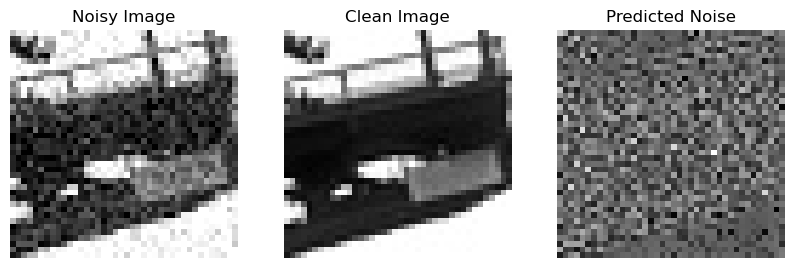

Batch 1010/2500   | Loss: 0.001583
Batch 1020/2500   | Loss: 0.001320
Batch 1030/2500   | Loss: 0.001602
Batch 1040/2500   | Loss: 0.001541
Batch 1050/2500   | Loss: 0.001527
Batch 1060/2500   | Loss: 0.001449
Batch 1070/2500   | Loss: 0.001606
Batch 1080/2500   | Loss: 0.001497
Batch 1090/2500   | Loss: 0.001512
Batch 1100/2500   | Loss: 0.001524
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_24_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_24_batch_800.pth
Batch 1110/2500   | Loss: 0.001630
Batch 1120/2500   | Loss: 0.001724
Batch 1130/2500   | Loss: 0.001605
Batch 1140/2500   | Loss: 0.001650
Batch 1150/2500   | Loss: 0.001651
Batch 1160/2500   | Loss: 0.001648
Batch 1170/2500   | Loss: 0.001718
Batch 1180/2500   | Loss: 0.001470
Batch 1190/2500   | Loss: 0.001646
Batch 1200/2

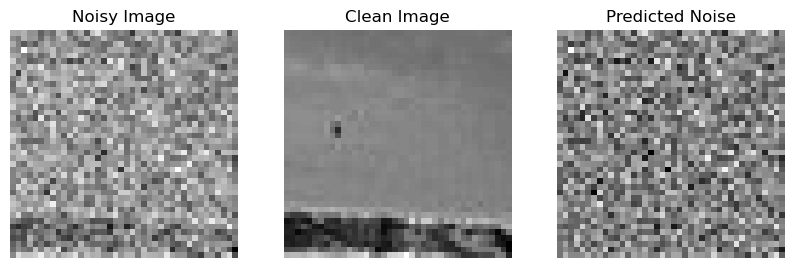

Batch 1510/2500   | Loss: 0.001641
Batch 1520/2500   | Loss: 0.001410
Batch 1530/2500   | Loss: 0.001832
Batch 1540/2500   | Loss: 0.001617
Batch 1550/2500   | Loss: 0.001567
Batch 1560/2500   | Loss: 0.001635
Batch 1570/2500   | Loss: 0.001543
Batch 1580/2500   | Loss: 0.001557
Batch 1590/2500   | Loss: 0.001673
Batch 1600/2500   | Loss: 0.001862
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_24_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_24_batch_1300.pth
Batch 1610/2500   | Loss: 0.001631
Batch 1620/2500   | Loss: 0.001570
Batch 1630/2500   | Loss: 0.001623
Batch 1640/2500   | Loss: 0.001544
Batch 1650/2500   | Loss: 0.001512
Batch 1660/2500   | Loss: 0.001572
Batch 1670/2500   | Loss: 0.001529
Batch 1680/2500   | Loss: 0.001497
Batch 1690/2500   | Loss: 0.001603
Batch 1700/

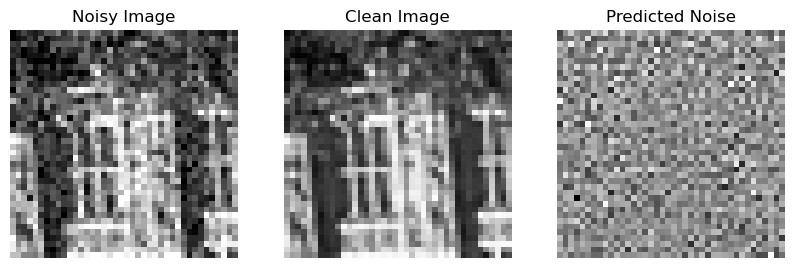

Batch 2010/2500   | Loss: 0.001630
Batch 2020/2500   | Loss: 0.001597
Batch 2030/2500   | Loss: 0.001493
Batch 2040/2500   | Loss: 0.001574
Batch 2050/2500   | Loss: 0.001600
Batch 2060/2500   | Loss: 0.001771
Batch 2070/2500   | Loss: 0.001384
Batch 2080/2500   | Loss: 0.001518
Batch 2090/2500   | Loss: 0.001589
Batch 2100/2500   | Loss: 0.001813
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_24_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_24_batch_1800.pth
Batch 2110/2500   | Loss: 0.001528
Batch 2120/2500   | Loss: 0.001517
Batch 2130/2500   | Loss: 0.001683
Batch 2140/2500   | Loss: 0.001603
Batch 2150/2500   | Loss: 0.001624
Batch 2160/2500   | Loss: 0.001597
Batch 2170/2500   | Loss: 0.001526
Batch 2180/2500   | Loss: 0.001619
Batch 2190/2500   | Loss: 0.001602
Batch 2200/

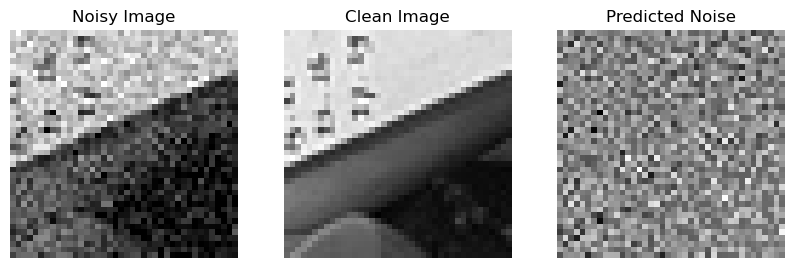

Batch 10/2500   | Loss: 0.001497
Batch 20/2500   | Loss: 0.001572
Batch 30/2500   | Loss: 0.001699
Batch 40/2500   | Loss: 0.001688
Batch 50/2500   | Loss: 0.001739
Batch 60/2500   | Loss: 0.001631
Batch 70/2500   | Loss: 0.001652
Batch 80/2500   | Loss: 0.001575
Batch 90/2500   | Loss: 0.001620
Batch 100/2500   | Loss: 0.001669
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_25_batch_100.pth
Batch 110/2500   | Loss: 0.001945
Batch 120/2500   | Loss: 0.001612
Batch 130/2500   | Loss: 0.001687
Batch 140/2500   | Loss: 0.001577
Batch 150/2500   | Loss: 0.001441
Batch 160/2500   | Loss: 0.001562
Batch 170/2500   | Loss: 0.001672
Batch 180/2500   | Loss: 0.001740
Batch 190/2500   | Loss: 0.001926
Batch 200/2500   | Loss: 0.001378
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_25_batch_200.pth
Batch 210/250

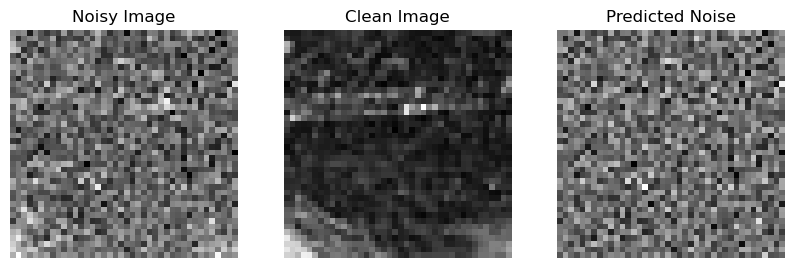

Batch 510/2500   | Loss: 0.001739
Batch 520/2500   | Loss: 0.001651
Batch 530/2500   | Loss: 0.001618
Batch 540/2500   | Loss: 0.001689
Batch 550/2500   | Loss: 0.001611
Batch 560/2500   | Loss: 0.001562
Batch 570/2500   | Loss: 0.001447
Batch 580/2500   | Loss: 0.001591
Batch 590/2500   | Loss: 0.001468
Batch 600/2500   | Loss: 0.001516
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_25_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_25_batch_300.pth
Batch 610/2500   | Loss: 0.001543
Batch 620/2500   | Loss: 0.001472
Batch 630/2500   | Loss: 0.001520
Batch 640/2500   | Loss: 0.001448
Batch 650/2500   | Loss: 0.001738
Batch 660/2500   | Loss: 0.001668
Batch 670/2500   | Loss: 0.001536
Batch 680/2500   | Loss: 0.001598
Batch 690/2500   | Loss: 0.001610
Batch 700/2500   | Loss: 0.00148

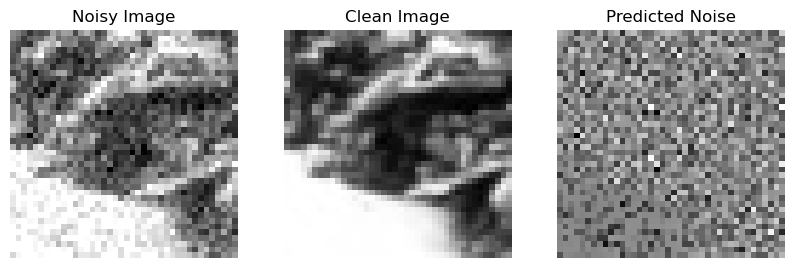

Batch 1010/2500   | Loss: 0.001503
Batch 1020/2500   | Loss: 0.001479
Batch 1030/2500   | Loss: 0.001836
Batch 1040/2500   | Loss: 0.001702
Batch 1050/2500   | Loss: 0.001558
Batch 1060/2500   | Loss: 0.001537
Batch 1070/2500   | Loss: 0.001473
Batch 1080/2500   | Loss: 0.001634
Batch 1090/2500   | Loss: 0.001569
Batch 1100/2500   | Loss: 0.001630
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_25_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_25_batch_800.pth
Batch 1110/2500   | Loss: 0.001650
Batch 1120/2500   | Loss: 0.001749
Batch 1130/2500   | Loss: 0.001632
Batch 1140/2500   | Loss: 0.001542
Batch 1150/2500   | Loss: 0.001675
Batch 1160/2500   | Loss: 0.001698
Batch 1170/2500   | Loss: 0.001639
Batch 1180/2500   | Loss: 0.001446
Batch 1190/2500   | Loss: 0.001508
Batch 1200/2

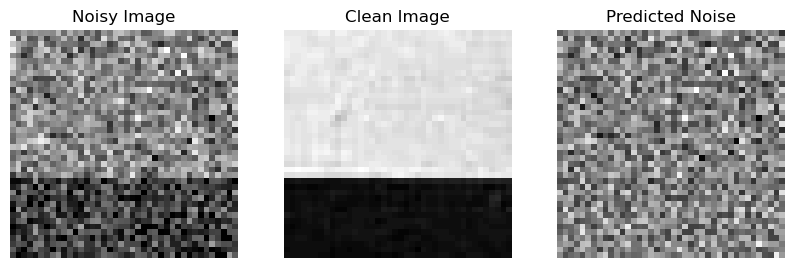

Batch 1510/2500   | Loss: 0.001612
Batch 1520/2500   | Loss: 0.001521
Batch 1530/2500   | Loss: 0.001669
Batch 1540/2500   | Loss: 0.001547
Batch 1550/2500   | Loss: 0.001496
Batch 1560/2500   | Loss: 0.001521
Batch 1570/2500   | Loss: 0.001584
Batch 1580/2500   | Loss: 0.001646
Batch 1590/2500   | Loss: 0.001385
Batch 1600/2500   | Loss: 0.001671
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_25_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_25_batch_1300.pth
Batch 1610/2500   | Loss: 0.001672
Batch 1620/2500   | Loss: 0.001637
Batch 1630/2500   | Loss: 0.001523
Batch 1640/2500   | Loss: 0.001443
Batch 1650/2500   | Loss: 0.001660
Batch 1660/2500   | Loss: 0.001559
Batch 1670/2500   | Loss: 0.001788
Batch 1680/2500   | Loss: 0.001586
Batch 1690/2500   | Loss: 0.001447
Batch 1700/

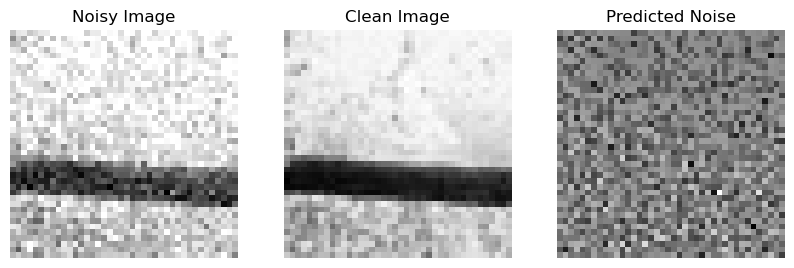

Batch 2010/2500   | Loss: 0.001624
Batch 2020/2500   | Loss: 0.001738
Batch 2030/2500   | Loss: 0.001812
Batch 2040/2500   | Loss: 0.001534
Batch 2050/2500   | Loss: 0.001686
Batch 2060/2500   | Loss: 0.001720
Batch 2070/2500   | Loss: 0.001494
Batch 2080/2500   | Loss: 0.001547
Batch 2090/2500   | Loss: 0.001691
Batch 2100/2500   | Loss: 0.001527
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_25_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_25_batch_1800.pth
Batch 2110/2500   | Loss: 0.001730
Batch 2120/2500   | Loss: 0.001534
Batch 2130/2500   | Loss: 0.001575
Batch 2140/2500   | Loss: 0.001616
Batch 2150/2500   | Loss: 0.001636
Batch 2160/2500   | Loss: 0.001540
Batch 2170/2500   | Loss: 0.001531
Batch 2180/2500   | Loss: 0.001639
Batch 2190/2500   | Loss: 0.001466
Batch 2200/

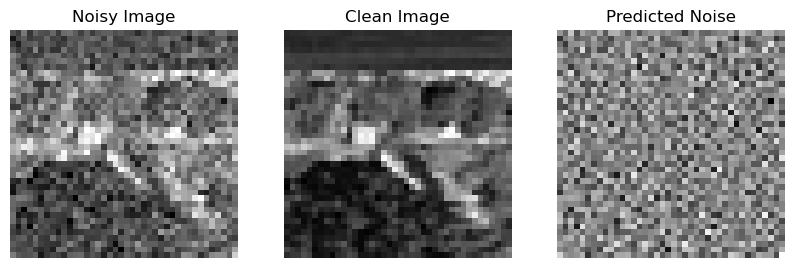

Batch 10/2500   | Loss: 0.001718
Batch 20/2500   | Loss: 0.001464
Batch 30/2500   | Loss: 0.001520
Batch 40/2500   | Loss: 0.001541
Batch 50/2500   | Loss: 0.001727
Batch 60/2500   | Loss: 0.001642
Batch 70/2500   | Loss: 0.001706
Batch 80/2500   | Loss: 0.001626
Batch 90/2500   | Loss: 0.001526
Batch 100/2500   | Loss: 0.001620
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_26_batch_100.pth
Batch 110/2500   | Loss: 0.001468
Batch 120/2500   | Loss: 0.001423
Batch 130/2500   | Loss: 0.001834
Batch 140/2500   | Loss: 0.001552
Batch 150/2500   | Loss: 0.001489
Batch 160/2500   | Loss: 0.001454
Batch 170/2500   | Loss: 0.001580
Batch 180/2500   | Loss: 0.001622
Batch 190/2500   | Loss: 0.001526
Batch 200/2500   | Loss: 0.001556
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_26_batch_200.pth
Batch 210/250

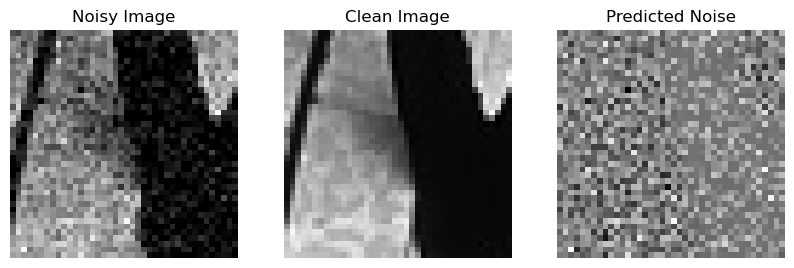

Batch 510/2500   | Loss: 0.001578
Batch 520/2500   | Loss: 0.001602
Batch 530/2500   | Loss: 0.001513
Batch 540/2500   | Loss: 0.001556
Batch 550/2500   | Loss: 0.001566
Batch 560/2500   | Loss: 0.001591
Batch 570/2500   | Loss: 0.001586
Batch 580/2500   | Loss: 0.001518
Batch 590/2500   | Loss: 0.001665
Batch 600/2500   | Loss: 0.001567
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_26_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_26_batch_300.pth
Batch 610/2500   | Loss: 0.001584
Batch 620/2500   | Loss: 0.001452
Batch 630/2500   | Loss: 0.001705
Batch 640/2500   | Loss: 0.001563
Batch 650/2500   | Loss: 0.001708
Batch 660/2500   | Loss: 0.001684
Batch 670/2500   | Loss: 0.001536
Batch 680/2500   | Loss: 0.001720
Batch 690/2500   | Loss: 0.001697
Batch 700/2500   | Loss: 0.00170

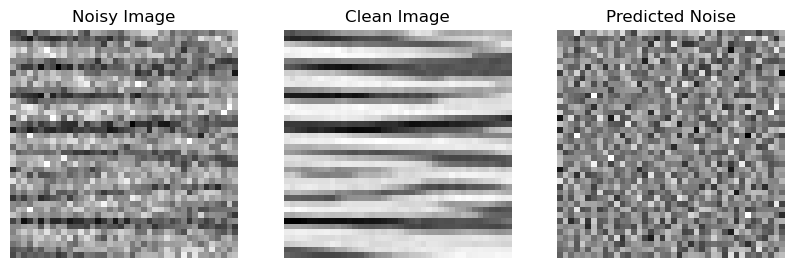

Batch 1010/2500   | Loss: 0.001570
Batch 1020/2500   | Loss: 0.001683
Batch 1030/2500   | Loss: 0.001434
Batch 1040/2500   | Loss: 0.001668
Batch 1050/2500   | Loss: 0.001690
Batch 1060/2500   | Loss: 0.001651
Batch 1070/2500   | Loss: 0.001853
Batch 1080/2500   | Loss: 0.001595
Batch 1090/2500   | Loss: 0.001613
Batch 1100/2500   | Loss: 0.001433
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_26_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_26_batch_800.pth
Batch 1110/2500   | Loss: 0.001491
Batch 1120/2500   | Loss: 0.001582
Batch 1130/2500   | Loss: 0.001697
Batch 1140/2500   | Loss: 0.001442
Batch 1150/2500   | Loss: 0.001561
Batch 1160/2500   | Loss: 0.001524
Batch 1170/2500   | Loss: 0.001719
Batch 1180/2500   | Loss: 0.001515
Batch 1190/2500   | Loss: 0.001470
Batch 1200/2

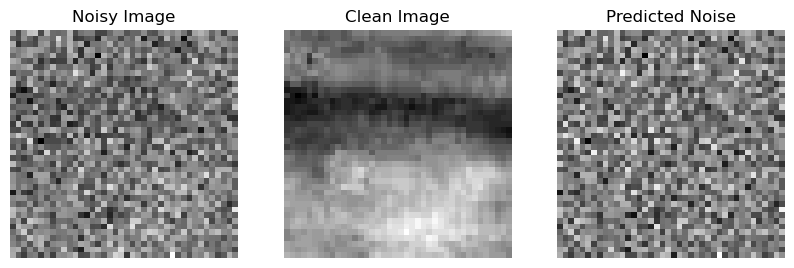

Batch 1510/2500   | Loss: 0.001811
Batch 1520/2500   | Loss: 0.001712
Batch 1530/2500   | Loss: 0.001656
Batch 1540/2500   | Loss: 0.001571
Batch 1550/2500   | Loss: 0.001595
Batch 1560/2500   | Loss: 0.001522
Batch 1570/2500   | Loss: 0.001862
Batch 1580/2500   | Loss: 0.001344
Batch 1590/2500   | Loss: 0.001691
Batch 1600/2500   | Loss: 0.001651
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_26_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_26_batch_1300.pth
Batch 1610/2500   | Loss: 0.001528
Batch 1620/2500   | Loss: 0.001673
Batch 1630/2500   | Loss: 0.001491
Batch 1640/2500   | Loss: 0.001482
Batch 1650/2500   | Loss: 0.001584
Batch 1660/2500   | Loss: 0.001617
Batch 1670/2500   | Loss: 0.001512
Batch 1680/2500   | Loss: 0.001613
Batch 1690/2500   | Loss: 0.001659
Batch 1700/

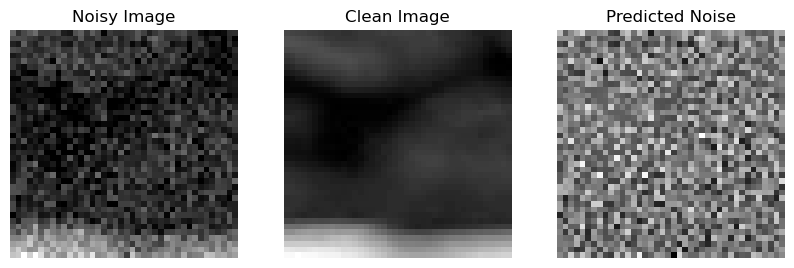

Batch 2010/2500   | Loss: 0.001516
Batch 2020/2500   | Loss: 0.001572
Batch 2030/2500   | Loss: 0.001643
Batch 2040/2500   | Loss: 0.001460
Batch 2050/2500   | Loss: 0.001653
Batch 2060/2500   | Loss: 0.001556
Batch 2070/2500   | Loss: 0.001529
Batch 2080/2500   | Loss: 0.001645
Batch 2090/2500   | Loss: 0.001751
Batch 2100/2500   | Loss: 0.001529
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_26_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_26_batch_1800.pth
Batch 2110/2500   | Loss: 0.001658
Batch 2120/2500   | Loss: 0.001637
Batch 2130/2500   | Loss: 0.001570
Batch 2140/2500   | Loss: 0.001671
Batch 2150/2500   | Loss: 0.001547
Batch 2160/2500   | Loss: 0.001618
Batch 2170/2500   | Loss: 0.001631
Batch 2180/2500   | Loss: 0.001637
Batch 2190/2500   | Loss: 0.001623
Batch 2200/

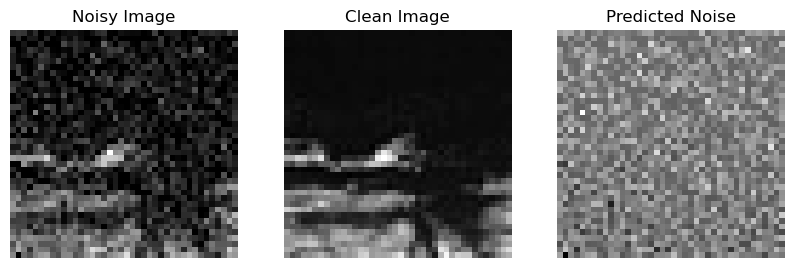

Batch 10/2500   | Loss: 0.001569
Batch 20/2500   | Loss: 0.001432
Batch 30/2500   | Loss: 0.001488
Batch 40/2500   | Loss: 0.001614
Batch 50/2500   | Loss: 0.001546
Batch 60/2500   | Loss: 0.001653
Batch 70/2500   | Loss: 0.001640
Batch 80/2500   | Loss: 0.001460
Batch 90/2500   | Loss: 0.001483
Batch 100/2500   | Loss: 0.001642
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_27_batch_100.pth
Batch 110/2500   | Loss: 0.001787
Batch 120/2500   | Loss: 0.001595
Batch 130/2500   | Loss: 0.001554
Batch 140/2500   | Loss: 0.001463
Batch 150/2500   | Loss: 0.001542
Batch 160/2500   | Loss: 0.001787
Batch 170/2500   | Loss: 0.001546
Batch 180/2500   | Loss: 0.001494
Batch 190/2500   | Loss: 0.001592
Batch 200/2500   | Loss: 0.001778
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_27_batch_200.pth
Batch 210/250

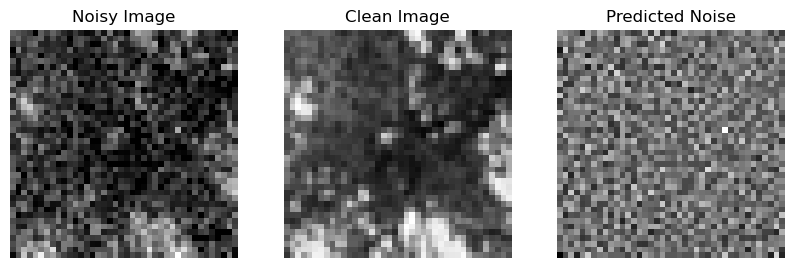

Batch 510/2500   | Loss: 0.001721
Batch 520/2500   | Loss: 0.001914
Batch 530/2500   | Loss: 0.001611
Batch 540/2500   | Loss: 0.001644
Batch 550/2500   | Loss: 0.001693
Batch 560/2500   | Loss: 0.001468
Batch 570/2500   | Loss: 0.001585
Batch 580/2500   | Loss: 0.001565
Batch 590/2500   | Loss: 0.001563
Batch 600/2500   | Loss: 0.001628
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_27_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_27_batch_300.pth
Batch 610/2500   | Loss: 0.001569
Batch 620/2500   | Loss: 0.001717
Batch 630/2500   | Loss: 0.001696
Batch 640/2500   | Loss: 0.001433
Batch 650/2500   | Loss: 0.001751
Batch 660/2500   | Loss: 0.001743
Batch 670/2500   | Loss: 0.001574
Batch 680/2500   | Loss: 0.001578
Batch 690/2500   | Loss: 0.001640
Batch 700/2500   | Loss: 0.00155

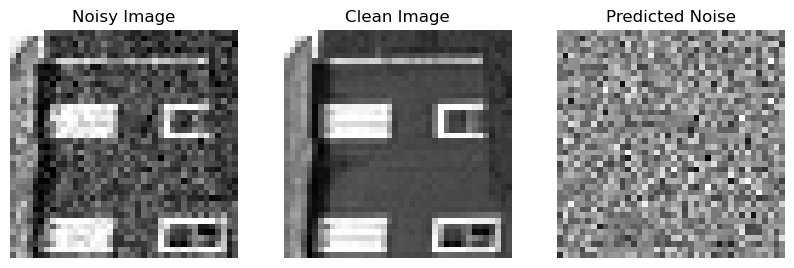

Batch 1010/2500   | Loss: 0.001512
Batch 1020/2500   | Loss: 0.001611
Batch 1030/2500   | Loss: 0.001582
Batch 1040/2500   | Loss: 0.001437
Batch 1050/2500   | Loss: 0.001572
Batch 1060/2500   | Loss: 0.001544
Batch 1070/2500   | Loss: 0.001385
Batch 1080/2500   | Loss: 0.001626
Batch 1090/2500   | Loss: 0.001784
Batch 1100/2500   | Loss: 0.001468
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_27_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_27_batch_800.pth
Batch 1110/2500   | Loss: 0.001746
Batch 1120/2500   | Loss: 0.001506
Batch 1130/2500   | Loss: 0.001615
Batch 1140/2500   | Loss: 0.001410
Batch 1150/2500   | Loss: 0.001477
Batch 1160/2500   | Loss: 0.001453
Batch 1170/2500   | Loss: 0.001969
Batch 1180/2500   | Loss: 0.001727
Batch 1190/2500   | Loss: 0.001645
Batch 1200/2

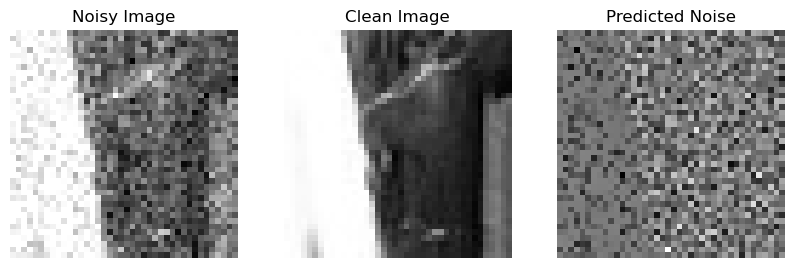

Batch 1510/2500   | Loss: 0.001505
Batch 1520/2500   | Loss: 0.001614
Batch 1530/2500   | Loss: 0.001680
Batch 1540/2500   | Loss: 0.001911
Batch 1550/2500   | Loss: 0.001678
Batch 1560/2500   | Loss: 0.001663
Batch 1570/2500   | Loss: 0.001660
Batch 1580/2500   | Loss: 0.001407
Batch 1590/2500   | Loss: 0.001607
Batch 1600/2500   | Loss: 0.001535
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_27_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_27_batch_1300.pth
Batch 1610/2500   | Loss: 0.001500
Batch 1620/2500   | Loss: 0.001655
Batch 1630/2500   | Loss: 0.001633
Batch 1640/2500   | Loss: 0.001526
Batch 1650/2500   | Loss: 0.001800
Batch 1660/2500   | Loss: 0.001559
Batch 1670/2500   | Loss: 0.001494
Batch 1680/2500   | Loss: 0.001881
Batch 1690/2500   | Loss: 0.001658
Batch 1700/

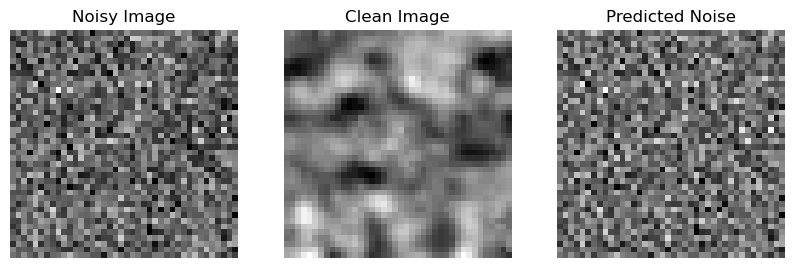

Batch 2010/2500   | Loss: 0.001823
Batch 2020/2500   | Loss: 0.001377
Batch 2030/2500   | Loss: 0.001528
Batch 2040/2500   | Loss: 0.001708
Batch 2050/2500   | Loss: 0.001630
Batch 2060/2500   | Loss: 0.001707
Batch 2070/2500   | Loss: 0.001740
Batch 2080/2500   | Loss: 0.001466
Batch 2090/2500   | Loss: 0.001545
Batch 2100/2500   | Loss: 0.001709
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_27_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_27_batch_1800.pth
Batch 2110/2500   | Loss: 0.001616
Batch 2120/2500   | Loss: 0.001543
Batch 2130/2500   | Loss: 0.001572
Batch 2140/2500   | Loss: 0.001549
Batch 2150/2500   | Loss: 0.001689
Batch 2160/2500   | Loss: 0.001446
Batch 2170/2500   | Loss: 0.001667
Batch 2180/2500   | Loss: 0.001478
Batch 2190/2500   | Loss: 0.001558
Batch 2200/

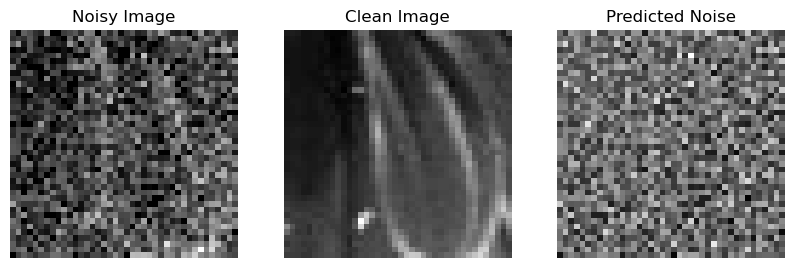

Batch 10/2500   | Loss: 0.001589
Batch 20/2500   | Loss: 0.001485
Batch 30/2500   | Loss: 0.001668
Batch 40/2500   | Loss: 0.001482
Batch 50/2500   | Loss: 0.001430
Batch 60/2500   | Loss: 0.001715
Batch 70/2500   | Loss: 0.001541
Batch 80/2500   | Loss: 0.001794
Batch 90/2500   | Loss: 0.001714
Batch 100/2500   | Loss: 0.001661
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_28_batch_100.pth
Batch 110/2500   | Loss: 0.001888
Batch 120/2500   | Loss: 0.001535
Batch 130/2500   | Loss: 0.001673
Batch 140/2500   | Loss: 0.001584
Batch 150/2500   | Loss: 0.001729
Batch 160/2500   | Loss: 0.001601
Batch 170/2500   | Loss: 0.001619
Batch 180/2500   | Loss: 0.001461
Batch 190/2500   | Loss: 0.001487
Batch 200/2500   | Loss: 0.001491
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_28_batch_200.pth
Batch 210/250

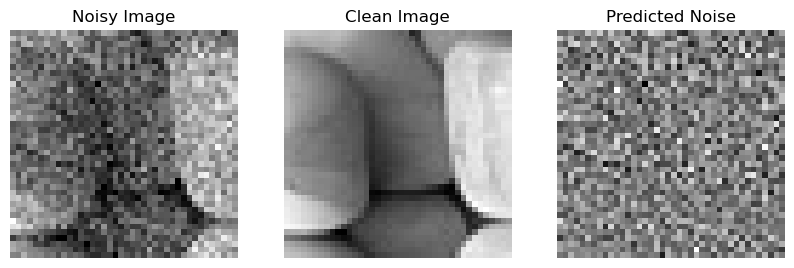

Batch 510/2500   | Loss: 0.001854
Batch 520/2500   | Loss: 0.001501
Batch 530/2500   | Loss: 0.001530
Batch 540/2500   | Loss: 0.001548
Batch 550/2500   | Loss: 0.001847
Batch 560/2500   | Loss: 0.001535
Batch 570/2500   | Loss: 0.001561
Batch 580/2500   | Loss: 0.001525
Batch 590/2500   | Loss: 0.001743
Batch 600/2500   | Loss: 0.001762
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_28_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_28_batch_300.pth
Batch 610/2500   | Loss: 0.001680
Batch 620/2500   | Loss: 0.001575
Batch 630/2500   | Loss: 0.001699
Batch 640/2500   | Loss: 0.001505
Batch 650/2500   | Loss: 0.001650
Batch 660/2500   | Loss: 0.001689
Batch 670/2500   | Loss: 0.001617
Batch 680/2500   | Loss: 0.001894
Batch 690/2500   | Loss: 0.001607
Batch 700/2500   | Loss: 0.00167

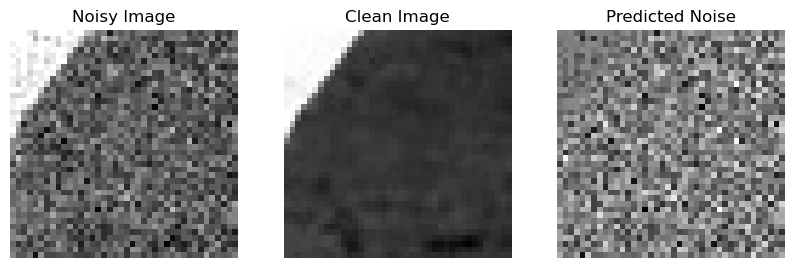

Batch 1010/2500   | Loss: 0.001626
Batch 1020/2500   | Loss: 0.001860
Batch 1030/2500   | Loss: 0.001523
Batch 1040/2500   | Loss: 0.001686
Batch 1050/2500   | Loss: 0.001509
Batch 1060/2500   | Loss: 0.001620
Batch 1070/2500   | Loss: 0.001608
Batch 1080/2500   | Loss: 0.001495
Batch 1090/2500   | Loss: 0.001475
Batch 1100/2500   | Loss: 0.001472
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_28_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_28_batch_800.pth
Batch 1110/2500   | Loss: 0.001636
Batch 1120/2500   | Loss: 0.001428
Batch 1130/2500   | Loss: 0.001557
Batch 1140/2500   | Loss: 0.001782
Batch 1150/2500   | Loss: 0.001583
Batch 1160/2500   | Loss: 0.001605
Batch 1170/2500   | Loss: 0.001503
Batch 1180/2500   | Loss: 0.001643
Batch 1190/2500   | Loss: 0.001716
Batch 1200/2

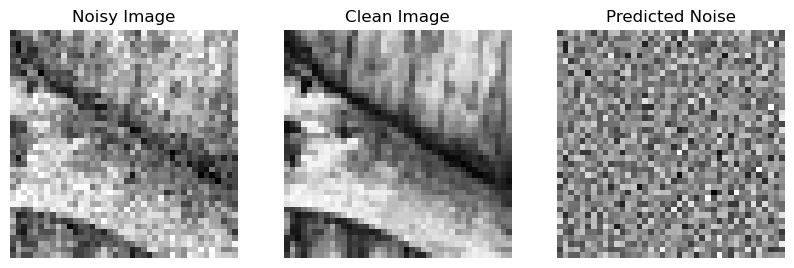

Batch 1510/2500   | Loss: 0.001722
Batch 1520/2500   | Loss: 0.001643
Batch 1530/2500   | Loss: 0.001532
Batch 1540/2500   | Loss: 0.001756
Batch 1550/2500   | Loss: 0.001707
Batch 1560/2500   | Loss: 0.001806
Batch 1570/2500   | Loss: 0.001492
Batch 1580/2500   | Loss: 0.001719
Batch 1590/2500   | Loss: 0.001517
Batch 1600/2500   | Loss: 0.001555
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_28_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_28_batch_1300.pth
Batch 1610/2500   | Loss: 0.001527
Batch 1620/2500   | Loss: 0.001635
Batch 1630/2500   | Loss: 0.001723
Batch 1640/2500   | Loss: 0.001628
Batch 1650/2500   | Loss: 0.001728
Batch 1660/2500   | Loss: 0.001536
Batch 1670/2500   | Loss: 0.001634
Batch 1680/2500   | Loss: 0.001481
Batch 1690/2500   | Loss: 0.001633
Batch 1700/

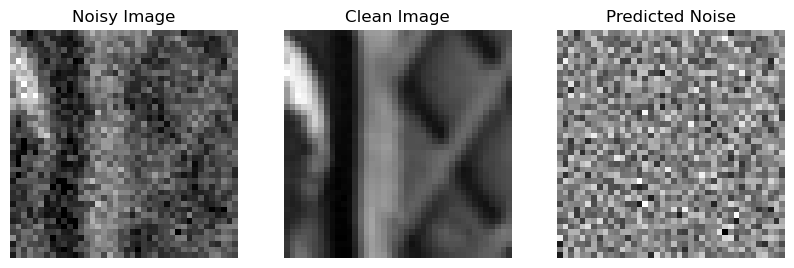

Batch 2010/2500   | Loss: 0.001491
Batch 2020/2500   | Loss: 0.001678
Batch 2030/2500   | Loss: 0.001629
Batch 2040/2500   | Loss: 0.001686
Batch 2050/2500   | Loss: 0.001592
Batch 2060/2500   | Loss: 0.001670
Batch 2070/2500   | Loss: 0.001700
Batch 2080/2500   | Loss: 0.001675
Batch 2090/2500   | Loss: 0.001768
Batch 2100/2500   | Loss: 0.001721
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_28_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_28_batch_1800.pth
Batch 2110/2500   | Loss: 0.001841
Batch 2120/2500   | Loss: 0.001562
Batch 2130/2500   | Loss: 0.001664
Batch 2140/2500   | Loss: 0.001578
Batch 2150/2500   | Loss: 0.001624
Batch 2160/2500   | Loss: 0.001625
Batch 2170/2500   | Loss: 0.001727
Batch 2180/2500   | Loss: 0.001544
Batch 2190/2500   | Loss: 0.001757
Batch 2200/

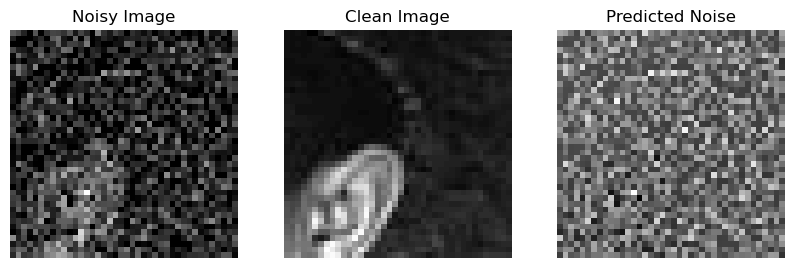

Batch 10/2500   | Loss: 0.001671
Batch 20/2500   | Loss: 0.001701
Batch 30/2500   | Loss: 0.001677
Batch 40/2500   | Loss: 0.001671
Batch 50/2500   | Loss: 0.001570
Batch 60/2500   | Loss: 0.001926
Batch 70/2500   | Loss: 0.001582
Batch 80/2500   | Loss: 0.001567
Batch 90/2500   | Loss: 0.001523
Batch 100/2500   | Loss: 0.001765
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_29_batch_100.pth
Batch 110/2500   | Loss: 0.001583
Batch 120/2500   | Loss: 0.001690
Batch 130/2500   | Loss: 0.001526
Batch 140/2500   | Loss: 0.001787
Batch 150/2500   | Loss: 0.001771
Batch 160/2500   | Loss: 0.001508
Batch 170/2500   | Loss: 0.001565
Batch 180/2500   | Loss: 0.001588
Batch 190/2500   | Loss: 0.001650
Batch 200/2500   | Loss: 0.001784
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_29_batch_200.pth
Batch 210/250

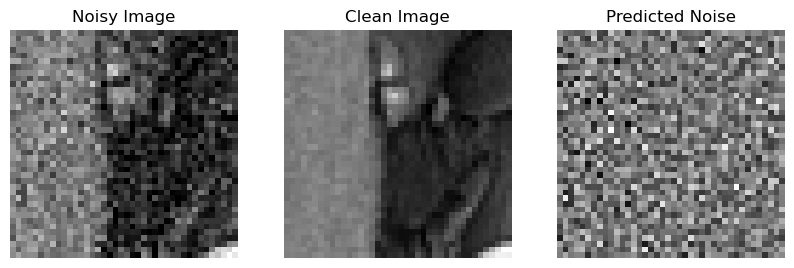

Batch 510/2500   | Loss: 0.001567
Batch 520/2500   | Loss: 0.001413
Batch 530/2500   | Loss: 0.001546
Batch 540/2500   | Loss: 0.001378
Batch 550/2500   | Loss: 0.001480
Batch 560/2500   | Loss: 0.001517
Batch 570/2500   | Loss: 0.001387
Batch 580/2500   | Loss: 0.001572
Batch 590/2500   | Loss: 0.001621
Batch 600/2500   | Loss: 0.001747
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_29_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_29_batch_300.pth
Batch 610/2500   | Loss: 0.001545
Batch 620/2500   | Loss: 0.001458
Batch 630/2500   | Loss: 0.001635
Batch 640/2500   | Loss: 0.001548
Batch 650/2500   | Loss: 0.001573
Batch 660/2500   | Loss: 0.001483
Batch 670/2500   | Loss: 0.001710
Batch 680/2500   | Loss: 0.001377
Batch 690/2500   | Loss: 0.001707
Batch 700/2500   | Loss: 0.00158

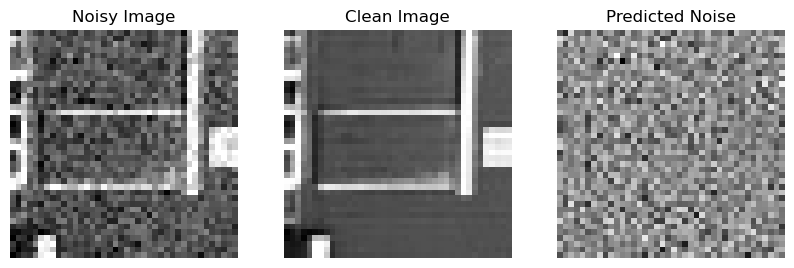

Batch 1010/2500   | Loss: 0.001571
Batch 1020/2500   | Loss: 0.001585
Batch 1030/2500   | Loss: 0.001575
Batch 1040/2500   | Loss: 0.001522
Batch 1050/2500   | Loss: 0.001444
Batch 1060/2500   | Loss: 0.001482
Batch 1070/2500   | Loss: 0.001528
Batch 1080/2500   | Loss: 0.001682
Batch 1090/2500   | Loss: 0.001772
Batch 1100/2500   | Loss: 0.001704
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_29_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_29_batch_800.pth
Batch 1110/2500   | Loss: 0.001588
Batch 1120/2500   | Loss: 0.001598
Batch 1130/2500   | Loss: 0.001478
Batch 1140/2500   | Loss: 0.001542
Batch 1150/2500   | Loss: 0.001804
Batch 1160/2500   | Loss: 0.001554
Batch 1170/2500   | Loss: 0.001517
Batch 1180/2500   | Loss: 0.001571
Batch 1190/2500   | Loss: 0.001650
Batch 1200/2

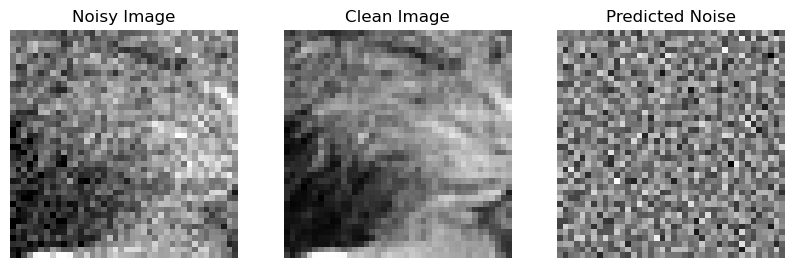

Batch 1510/2500   | Loss: 0.001578
Batch 1520/2500   | Loss: 0.001786
Batch 1530/2500   | Loss: 0.001752
Batch 1540/2500   | Loss: 0.001679
Batch 1550/2500   | Loss: 0.001513
Batch 1560/2500   | Loss: 0.001737
Batch 1570/2500   | Loss: 0.001665
Batch 1580/2500   | Loss: 0.001532
Batch 1590/2500   | Loss: 0.001657
Batch 1600/2500   | Loss: 0.001638
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_29_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_29_batch_1300.pth
Batch 1610/2500   | Loss: 0.001767
Batch 1620/2500   | Loss: 0.001752
Batch 1630/2500   | Loss: 0.001655
Batch 1640/2500   | Loss: 0.001472
Batch 1650/2500   | Loss: 0.001360
Batch 1660/2500   | Loss: 0.001764
Batch 1670/2500   | Loss: 0.001646
Batch 1680/2500   | Loss: 0.001459
Batch 1690/2500   | Loss: 0.001647
Batch 1700/

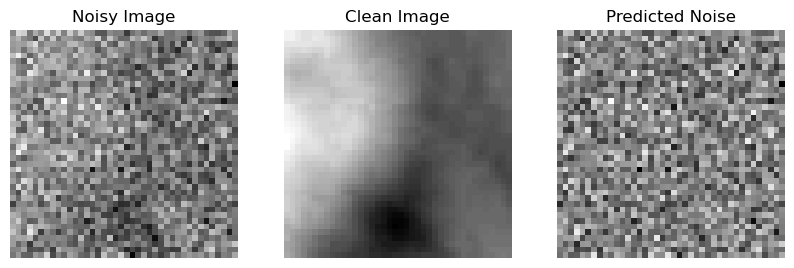

Batch 2010/2500   | Loss: 0.001583
Batch 2020/2500   | Loss: 0.001619
Batch 2030/2500   | Loss: 0.001683
Batch 2040/2500   | Loss: 0.001502
Batch 2050/2500   | Loss: 0.001446
Batch 2060/2500   | Loss: 0.001523
Batch 2070/2500   | Loss: 0.001435
Batch 2080/2500   | Loss: 0.001490
Batch 2090/2500   | Loss: 0.001611
Batch 2100/2500   | Loss: 0.001657
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_29_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_29_batch_1800.pth
Batch 2110/2500   | Loss: 0.001549
Batch 2120/2500   | Loss: 0.001613
Batch 2130/2500   | Loss: 0.001614
Batch 2140/2500   | Loss: 0.001661
Batch 2150/2500   | Loss: 0.001481
Batch 2160/2500   | Loss: 0.001511
Batch 2170/2500   | Loss: 0.001588
Batch 2180/2500   | Loss: 0.001583
Batch 2190/2500   | Loss: 0.001385
Batch 2200/

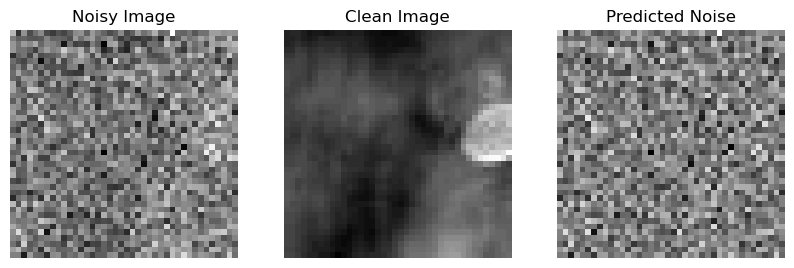

Batch 10/2500   | Loss: 0.001656
Batch 20/2500   | Loss: 0.001747
Batch 30/2500   | Loss: 0.001662
Batch 40/2500   | Loss: 0.001581
Batch 50/2500   | Loss: 0.001433
Batch 60/2500   | Loss: 0.001615
Batch 70/2500   | Loss: 0.001551
Batch 80/2500   | Loss: 0.001657
Batch 90/2500   | Loss: 0.001490
Batch 100/2500   | Loss: 0.001418
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_30_batch_100.pth
Batch 110/2500   | Loss: 0.001556
Batch 120/2500   | Loss: 0.001616
Batch 130/2500   | Loss: 0.001613
Batch 140/2500   | Loss: 0.001454
Batch 150/2500   | Loss: 0.001526
Batch 160/2500   | Loss: 0.001753
Batch 170/2500   | Loss: 0.001587
Batch 180/2500   | Loss: 0.001666
Batch 190/2500   | Loss: 0.001740
Batch 200/2500   | Loss: 0.001616
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_30_batch_200.pth
Batch 210/250

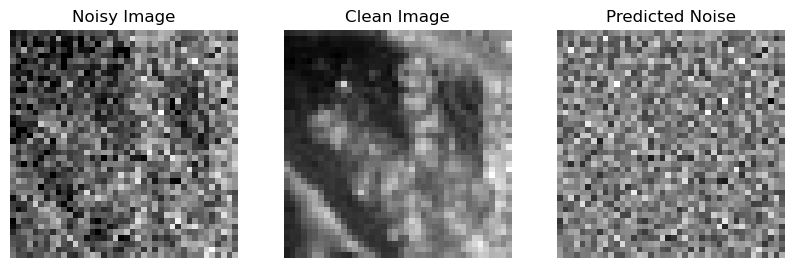

Batch 510/2500   | Loss: 0.001394
Batch 520/2500   | Loss: 0.001536
Batch 530/2500   | Loss: 0.001575
Batch 540/2500   | Loss: 0.001702
Batch 550/2500   | Loss: 0.001277
Batch 560/2500   | Loss: 0.001556
Batch 570/2500   | Loss: 0.001848
Batch 580/2500   | Loss: 0.001654
Batch 590/2500   | Loss: 0.001400
Batch 600/2500   | Loss: 0.001477
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_30_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_30_batch_300.pth
Batch 610/2500   | Loss: 0.001686
Batch 620/2500   | Loss: 0.001676
Batch 630/2500   | Loss: 0.001635
Batch 640/2500   | Loss: 0.001458
Batch 650/2500   | Loss: 0.001589
Batch 660/2500   | Loss: 0.001529
Batch 670/2500   | Loss: 0.001513
Batch 680/2500   | Loss: 0.001523
Batch 690/2500   | Loss: 0.001504
Batch 700/2500   | Loss: 0.00151

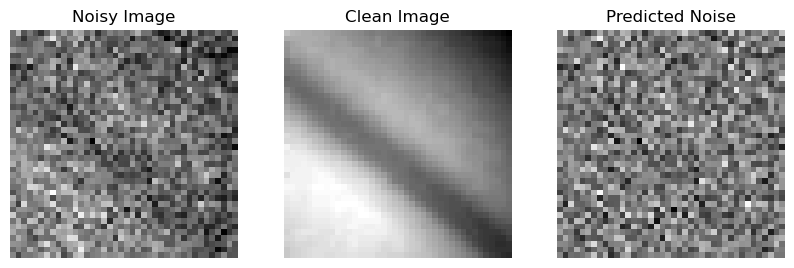

Batch 1010/2500   | Loss: 0.001723
Batch 1020/2500   | Loss: 0.001655
Batch 1030/2500   | Loss: 0.001601
Batch 1040/2500   | Loss: 0.001386
Batch 1050/2500   | Loss: 0.001429
Batch 1060/2500   | Loss: 0.001599
Batch 1070/2500   | Loss: 0.001508
Batch 1080/2500   | Loss: 0.001533
Batch 1090/2500   | Loss: 0.001633
Batch 1100/2500   | Loss: 0.001517
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_30_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_30_batch_800.pth
Batch 1110/2500   | Loss: 0.001793
Batch 1120/2500   | Loss: 0.001458
Batch 1130/2500   | Loss: 0.001743
Batch 1140/2500   | Loss: 0.001486
Batch 1150/2500   | Loss: 0.001650
Batch 1160/2500   | Loss: 0.001599
Batch 1170/2500   | Loss: 0.001756
Batch 1180/2500   | Loss: 0.001676
Batch 1190/2500   | Loss: 0.001476
Batch 1200/2

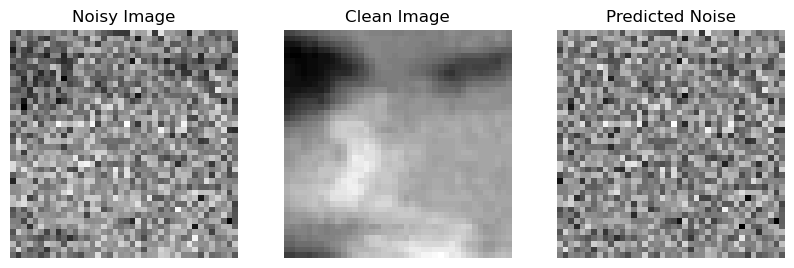

Batch 1510/2500   | Loss: 0.001561
Batch 1520/2500   | Loss: 0.001564
Batch 1530/2500   | Loss: 0.001562
Batch 1540/2500   | Loss: 0.001537
Batch 1550/2500   | Loss: 0.001496
Batch 1560/2500   | Loss: 0.001676
Batch 1570/2500   | Loss: 0.001594
Batch 1580/2500   | Loss: 0.001534
Batch 1590/2500   | Loss: 0.001511
Batch 1600/2500   | Loss: 0.001450
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_30_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_30_batch_1300.pth
Batch 1610/2500   | Loss: 0.001584
Batch 1620/2500   | Loss: 0.001533
Batch 1630/2500   | Loss: 0.001772
Batch 1640/2500   | Loss: 0.001776
Batch 1650/2500   | Loss: 0.001644
Batch 1660/2500   | Loss: 0.001535
Batch 1670/2500   | Loss: 0.001637
Batch 1680/2500   | Loss: 0.001491
Batch 1690/2500   | Loss: 0.001550
Batch 1700/

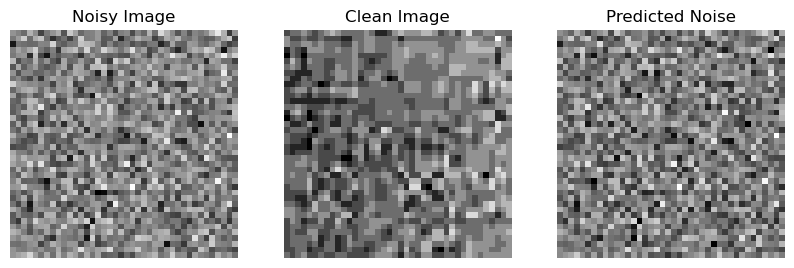

Batch 2010/2500   | Loss: 0.001467
Batch 2020/2500   | Loss: 0.001551
Batch 2030/2500   | Loss: 0.001840
Batch 2040/2500   | Loss: 0.001626
Batch 2050/2500   | Loss: 0.001699
Batch 2060/2500   | Loss: 0.001701
Batch 2070/2500   | Loss: 0.001724
Batch 2080/2500   | Loss: 0.001476
Batch 2090/2500   | Loss: 0.001443
Batch 2100/2500   | Loss: 0.001668
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_30_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_30_batch_1800.pth
Batch 2110/2500   | Loss: 0.001541
Batch 2120/2500   | Loss: 0.001547
Batch 2130/2500   | Loss: 0.001598
Batch 2140/2500   | Loss: 0.001653
Batch 2150/2500   | Loss: 0.001598
Batch 2160/2500   | Loss: 0.001649
Batch 2170/2500   | Loss: 0.001648
Batch 2180/2500   | Loss: 0.001439
Batch 2190/2500   | Loss: 0.001675
Batch 2200/

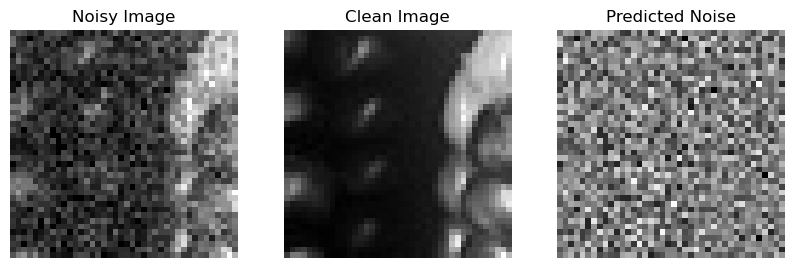

Batch 10/2500   | Loss: 0.001708
Batch 20/2500   | Loss: 0.001512
Batch 30/2500   | Loss: 0.001565
Batch 40/2500   | Loss: 0.001774
Batch 50/2500   | Loss: 0.001524
Batch 60/2500   | Loss: 0.001669
Batch 70/2500   | Loss: 0.001527
Batch 80/2500   | Loss: 0.001684
Batch 90/2500   | Loss: 0.001788
Batch 100/2500   | Loss: 0.001388
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_31_batch_100.pth
Batch 110/2500   | Loss: 0.001770
Batch 120/2500   | Loss: 0.001489
Batch 130/2500   | Loss: 0.001475
Batch 140/2500   | Loss: 0.001576
Batch 150/2500   | Loss: 0.001386
Batch 160/2500   | Loss: 0.001625
Batch 170/2500   | Loss: 0.001788
Batch 180/2500   | Loss: 0.001432
Batch 190/2500   | Loss: 0.001558
Batch 200/2500   | Loss: 0.001552
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_31_batch_200.pth
Batch 210/250

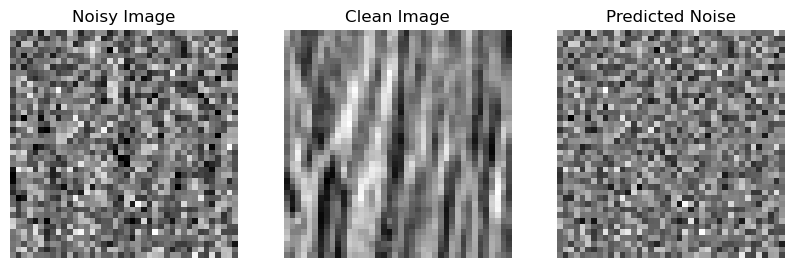

Batch 510/2500   | Loss: 0.001691
Batch 520/2500   | Loss: 0.001372
Batch 530/2500   | Loss: 0.001614
Batch 540/2500   | Loss: 0.001467
Batch 550/2500   | Loss: 0.001487
Batch 560/2500   | Loss: 0.001579
Batch 570/2500   | Loss: 0.001421
Batch 580/2500   | Loss: 0.001583
Batch 590/2500   | Loss: 0.001809
Batch 600/2500   | Loss: 0.001702
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_31_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_31_batch_300.pth
Batch 610/2500   | Loss: 0.001680
Batch 620/2500   | Loss: 0.001359
Batch 630/2500   | Loss: 0.001476
Batch 640/2500   | Loss: 0.001517
Batch 650/2500   | Loss: 0.001722
Batch 660/2500   | Loss: 0.001561
Batch 670/2500   | Loss: 0.001599
Batch 680/2500   | Loss: 0.001617
Batch 690/2500   | Loss: 0.001615
Batch 700/2500   | Loss: 0.00183

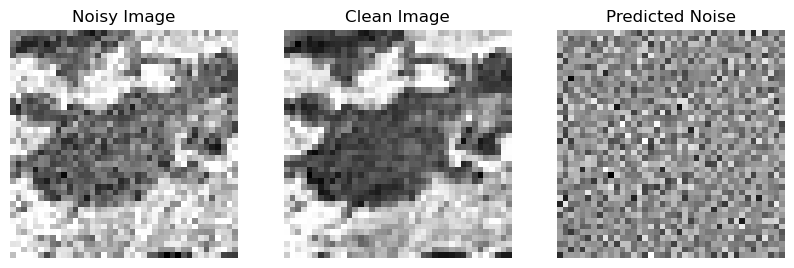

Batch 1010/2500   | Loss: 0.001674
Batch 1020/2500   | Loss: 0.001570
Batch 1030/2500   | Loss: 0.001603
Batch 1040/2500   | Loss: 0.001781
Batch 1050/2500   | Loss: 0.001467
Batch 1060/2500   | Loss: 0.001632
Batch 1070/2500   | Loss: 0.001693
Batch 1080/2500   | Loss: 0.001593
Batch 1090/2500   | Loss: 0.001356
Batch 1100/2500   | Loss: 0.001644
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_31_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_31_batch_800.pth
Batch 1110/2500   | Loss: 0.001478
Batch 1120/2500   | Loss: 0.001632
Batch 1130/2500   | Loss: 0.001679
Batch 1140/2500   | Loss: 0.001620
Batch 1150/2500   | Loss: 0.001631
Batch 1160/2500   | Loss: 0.001508
Batch 1170/2500   | Loss: 0.001614
Batch 1180/2500   | Loss: 0.001475
Batch 1190/2500   | Loss: 0.001414
Batch 1200/2

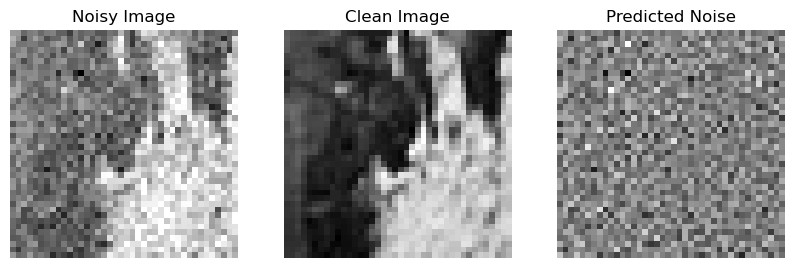

Batch 1510/2500   | Loss: 0.001659
Batch 1520/2500   | Loss: 0.001585
Batch 1530/2500   | Loss: 0.001469
Batch 1540/2500   | Loss: 0.001333
Batch 1550/2500   | Loss: 0.001412
Batch 1560/2500   | Loss: 0.001514
Batch 1570/2500   | Loss: 0.001693
Batch 1580/2500   | Loss: 0.001455
Batch 1590/2500   | Loss: 0.001576
Batch 1600/2500   | Loss: 0.001521
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_31_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_31_batch_1300.pth
Batch 1610/2500   | Loss: 0.001578
Batch 1620/2500   | Loss: 0.001551
Batch 1630/2500   | Loss: 0.001540
Batch 1640/2500   | Loss: 0.001758
Batch 1650/2500   | Loss: 0.001672
Batch 1660/2500   | Loss: 0.001485
Batch 1670/2500   | Loss: 0.001422
Batch 1680/2500   | Loss: 0.001637
Batch 1690/2500   | Loss: 0.001555
Batch 1700/

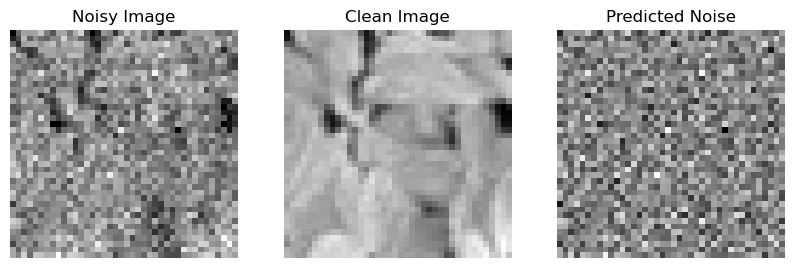

Batch 2010/2500   | Loss: 0.001688
Batch 2020/2500   | Loss: 0.001571
Batch 2030/2500   | Loss: 0.001650
Batch 2040/2500   | Loss: 0.001638
Batch 2050/2500   | Loss: 0.001800
Batch 2060/2500   | Loss: 0.001674
Batch 2070/2500   | Loss: 0.001561
Batch 2080/2500   | Loss: 0.001513
Batch 2090/2500   | Loss: 0.001587
Batch 2100/2500   | Loss: 0.001606
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_31_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_31_batch_1800.pth
Batch 2110/2500   | Loss: 0.001539
Batch 2120/2500   | Loss: 0.001575
Batch 2130/2500   | Loss: 0.001751
Batch 2140/2500   | Loss: 0.001497
Batch 2150/2500   | Loss: 0.001508
Batch 2160/2500   | Loss: 0.001521
Batch 2170/2500   | Loss: 0.001625
Batch 2180/2500   | Loss: 0.001513
Batch 2190/2500   | Loss: 0.001560
Batch 2200/

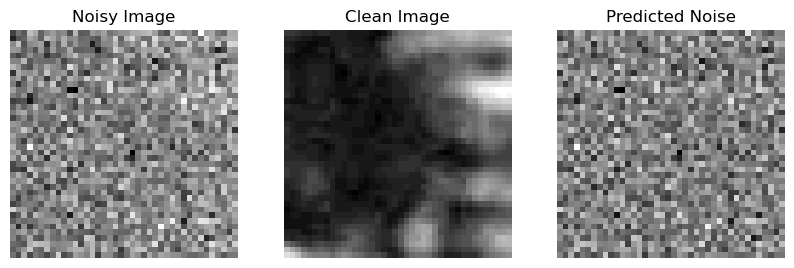

Batch 10/2500   | Loss: 0.001641
Batch 20/2500   | Loss: 0.001629
Batch 30/2500   | Loss: 0.001569
Batch 40/2500   | Loss: 0.001602
Batch 50/2500   | Loss: 0.001552
Batch 60/2500   | Loss: 0.001597
Batch 70/2500   | Loss: 0.001649
Batch 80/2500   | Loss: 0.001610
Batch 90/2500   | Loss: 0.001794
Batch 100/2500   | Loss: 0.001471
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_32_batch_100.pth
Batch 110/2500   | Loss: 0.001686
Batch 120/2500   | Loss: 0.001524
Batch 130/2500   | Loss: 0.001616
Batch 140/2500   | Loss: 0.001666
Batch 150/2500   | Loss: 0.001519
Batch 160/2500   | Loss: 0.001753
Batch 170/2500   | Loss: 0.001500
Batch 180/2500   | Loss: 0.001475
Batch 190/2500   | Loss: 0.001684
Batch 200/2500   | Loss: 0.001518
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_32_batch_200.pth
Batch 210/250

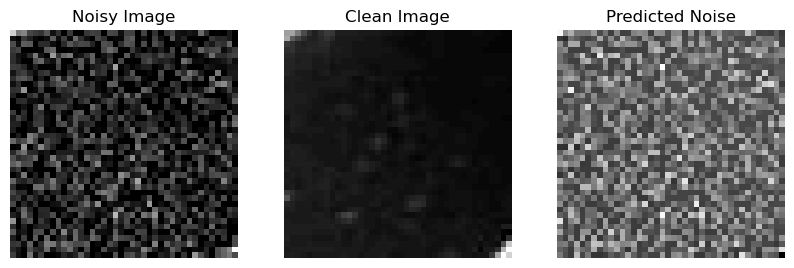

Batch 510/2500   | Loss: 0.001530
Batch 520/2500   | Loss: 0.001820
Batch 530/2500   | Loss: 0.001491
Batch 540/2500   | Loss: 0.001454
Batch 550/2500   | Loss: 0.001532
Batch 560/2500   | Loss: 0.001515
Batch 570/2500   | Loss: 0.001653
Batch 580/2500   | Loss: 0.001570
Batch 590/2500   | Loss: 0.001888
Batch 600/2500   | Loss: 0.001621
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_32_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_32_batch_300.pth
Batch 610/2500   | Loss: 0.001491
Batch 620/2500   | Loss: 0.001631
Batch 630/2500   | Loss: 0.001705
Batch 640/2500   | Loss: 0.001581
Batch 650/2500   | Loss: 0.001650
Batch 660/2500   | Loss: 0.001542
Batch 670/2500   | Loss: 0.001792
Batch 680/2500   | Loss: 0.001460
Batch 690/2500   | Loss: 0.001598
Batch 700/2500   | Loss: 0.00160

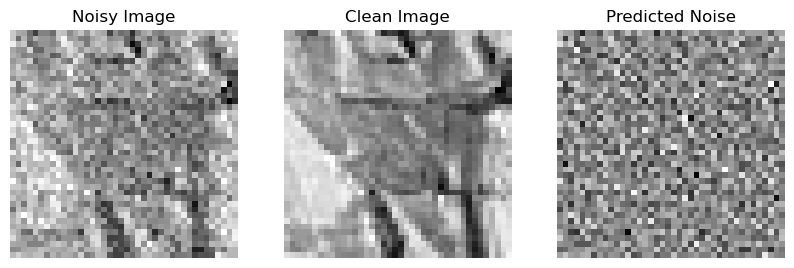

Batch 1010/2500   | Loss: 0.001668
Batch 1020/2500   | Loss: 0.001572
Batch 1030/2500   | Loss: 0.001524
Batch 1040/2500   | Loss: 0.001504
Batch 1050/2500   | Loss: 0.001615
Batch 1060/2500   | Loss: 0.001562
Batch 1070/2500   | Loss: 0.001381
Batch 1080/2500   | Loss: 0.001654
Batch 1090/2500   | Loss: 0.001444
Batch 1100/2500   | Loss: 0.001466
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_32_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_32_batch_800.pth
Batch 1110/2500   | Loss: 0.001399
Batch 1120/2500   | Loss: 0.001631
Batch 1130/2500   | Loss: 0.001666
Batch 1140/2500   | Loss: 0.001593
Batch 1150/2500   | Loss: 0.001467
Batch 1160/2500   | Loss: 0.001601
Batch 1170/2500   | Loss: 0.001571
Batch 1180/2500   | Loss: 0.001676
Batch 1190/2500   | Loss: 0.001558
Batch 1200/2

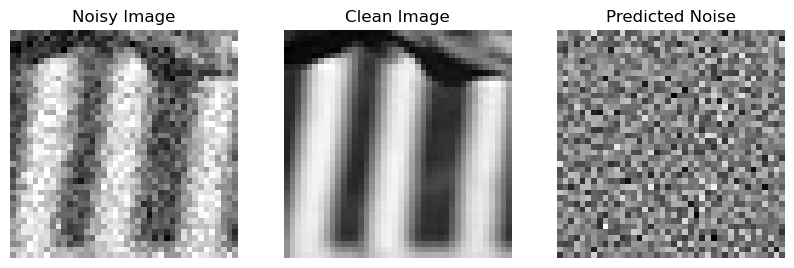

Batch 1510/2500   | Loss: 0.001708
Batch 1520/2500   | Loss: 0.001728
Batch 1530/2500   | Loss: 0.001666
Batch 1540/2500   | Loss: 0.001590
Batch 1550/2500   | Loss: 0.001412
Batch 1560/2500   | Loss: 0.001609
Batch 1570/2500   | Loss: 0.001822
Batch 1580/2500   | Loss: 0.001333
Batch 1590/2500   | Loss: 0.001499
Batch 1600/2500   | Loss: 0.001621
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_32_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_32_batch_1300.pth
Batch 1610/2500   | Loss: 0.001557
Batch 1620/2500   | Loss: 0.001795
Batch 1630/2500   | Loss: 0.001706
Batch 1640/2500   | Loss: 0.001821
Batch 1650/2500   | Loss: 0.001501
Batch 1660/2500   | Loss: 0.001544
Batch 1670/2500   | Loss: 0.001482
Batch 1680/2500   | Loss: 0.001570
Batch 1690/2500   | Loss: 0.001467
Batch 1700/

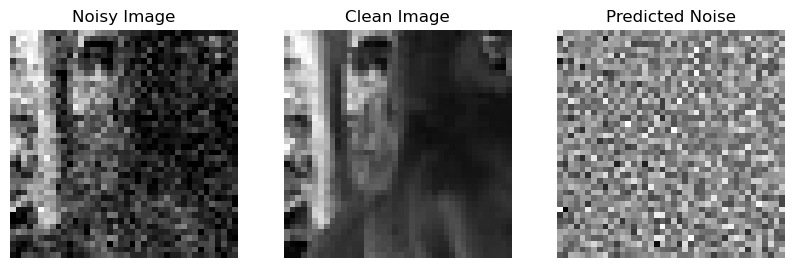

Batch 2010/2500   | Loss: 0.001446
Batch 2020/2500   | Loss: 0.001776
Batch 2030/2500   | Loss: 0.001660
Batch 2040/2500   | Loss: 0.001558
Batch 2050/2500   | Loss: 0.001848
Batch 2060/2500   | Loss: 0.001602
Batch 2070/2500   | Loss: 0.001489
Batch 2080/2500   | Loss: 0.001659
Batch 2090/2500   | Loss: 0.001566
Batch 2100/2500   | Loss: 0.001704
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_32_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_32_batch_1800.pth
Batch 2110/2500   | Loss: 0.001424
Batch 2120/2500   | Loss: 0.001754
Batch 2130/2500   | Loss: 0.001661
Batch 2140/2500   | Loss: 0.001795
Batch 2150/2500   | Loss: 0.001565
Batch 2160/2500   | Loss: 0.001445
Batch 2170/2500   | Loss: 0.001606
Batch 2180/2500   | Loss: 0.001606
Batch 2190/2500   | Loss: 0.001581
Batch 2200/

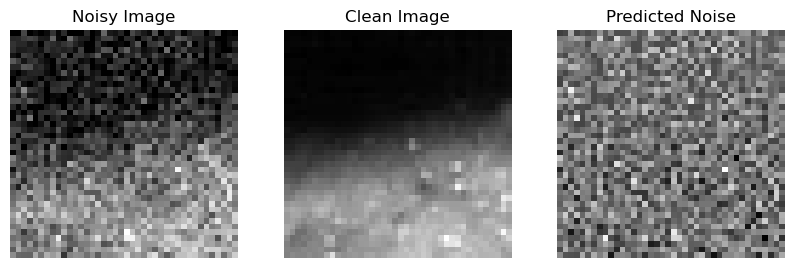

Batch 10/2500   | Loss: 0.001675
Batch 20/2500   | Loss: 0.001570
Batch 30/2500   | Loss: 0.001629
Batch 40/2500   | Loss: 0.001669
Batch 50/2500   | Loss: 0.001544
Batch 60/2500   | Loss: 0.001509
Batch 70/2500   | Loss: 0.001571
Batch 80/2500   | Loss: 0.001388
Batch 90/2500   | Loss: 0.001770
Batch 100/2500   | Loss: 0.001561
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_33_batch_100.pth
Batch 110/2500   | Loss: 0.001542
Batch 120/2500   | Loss: 0.001737
Batch 130/2500   | Loss: 0.001587
Batch 140/2500   | Loss: 0.001476
Batch 150/2500   | Loss: 0.001691
Batch 160/2500   | Loss: 0.001628
Batch 170/2500   | Loss: 0.001824
Batch 180/2500   | Loss: 0.001559
Batch 190/2500   | Loss: 0.001432
Batch 200/2500   | Loss: 0.001445
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_33_batch_200.pth
Batch 210/250

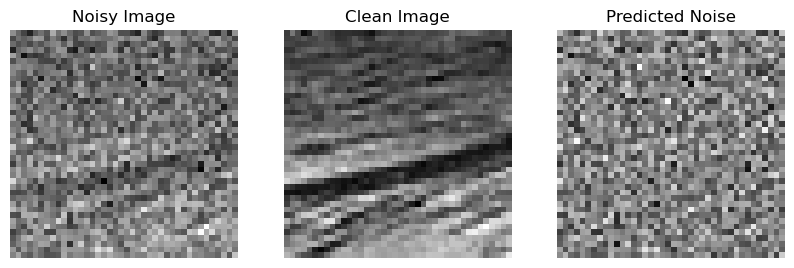

Batch 510/2500   | Loss: 0.001467
Batch 520/2500   | Loss: 0.001864
Batch 530/2500   | Loss: 0.001479
Batch 540/2500   | Loss: 0.001668
Batch 550/2500   | Loss: 0.001504
Batch 560/2500   | Loss: 0.001583
Batch 570/2500   | Loss: 0.001452
Batch 580/2500   | Loss: 0.001699
Batch 590/2500   | Loss: 0.001602
Batch 600/2500   | Loss: 0.001560
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_33_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_33_batch_300.pth
Batch 610/2500   | Loss: 0.001490
Batch 620/2500   | Loss: 0.001475
Batch 630/2500   | Loss: 0.001878
Batch 640/2500   | Loss: 0.001559
Batch 650/2500   | Loss: 0.001583
Batch 660/2500   | Loss: 0.001651
Batch 670/2500   | Loss: 0.001462
Batch 680/2500   | Loss: 0.001462
Batch 690/2500   | Loss: 0.001522
Batch 700/2500   | Loss: 0.00155

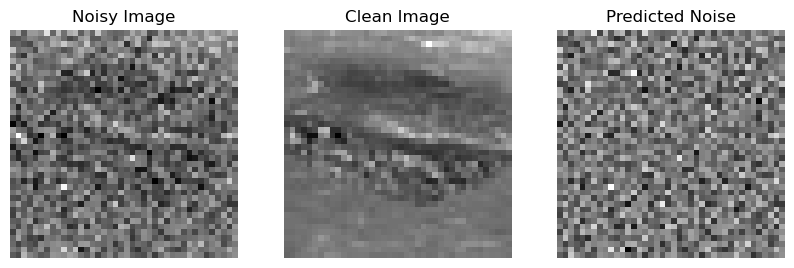

Batch 1010/2500   | Loss: 0.001400
Batch 1020/2500   | Loss: 0.001595
Batch 1030/2500   | Loss: 0.001388
Batch 1040/2500   | Loss: 0.001554
Batch 1050/2500   | Loss: 0.001708
Batch 1060/2500   | Loss: 0.001770
Batch 1070/2500   | Loss: 0.001572
Batch 1080/2500   | Loss: 0.001582
Batch 1090/2500   | Loss: 0.001642
Batch 1100/2500   | Loss: 0.001476
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_33_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_33_batch_800.pth
Batch 1110/2500   | Loss: 0.001514
Batch 1120/2500   | Loss: 0.001637
Batch 1130/2500   | Loss: 0.001674
Batch 1140/2500   | Loss: 0.001490
Batch 1150/2500   | Loss: 0.001665
Batch 1160/2500   | Loss: 0.001568
Batch 1170/2500   | Loss: 0.001459
Batch 1180/2500   | Loss: 0.001583
Batch 1190/2500   | Loss: 0.001579
Batch 1200/2

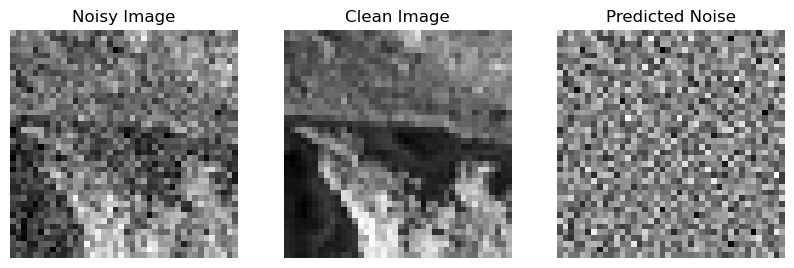

Batch 1510/2500   | Loss: 0.001549
Batch 1520/2500   | Loss: 0.001749
Batch 1530/2500   | Loss: 0.001439
Batch 1540/2500   | Loss: 0.001738
Batch 1550/2500   | Loss: 0.001561
Batch 1560/2500   | Loss: 0.001541
Batch 1570/2500   | Loss: 0.001534
Batch 1580/2500   | Loss: 0.001556
Batch 1590/2500   | Loss: 0.001428
Batch 1600/2500   | Loss: 0.001651
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_33_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_33_batch_1300.pth
Batch 1610/2500   | Loss: 0.001504
Batch 1620/2500   | Loss: 0.001654
Batch 1630/2500   | Loss: 0.001511
Batch 1640/2500   | Loss: 0.001535
Batch 1650/2500   | Loss: 0.001451
Batch 1660/2500   | Loss: 0.001513
Batch 1670/2500   | Loss: 0.001609
Batch 1680/2500   | Loss: 0.001537
Batch 1690/2500   | Loss: 0.001690
Batch 1700/

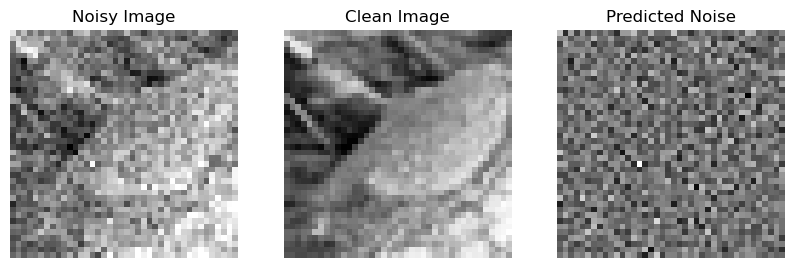

Batch 2010/2500   | Loss: 0.001485
Batch 2020/2500   | Loss: 0.001567
Batch 2030/2500   | Loss: 0.001791
Batch 2040/2500   | Loss: 0.001592
Batch 2050/2500   | Loss: 0.001810
Batch 2060/2500   | Loss: 0.001672
Batch 2070/2500   | Loss: 0.001830
Batch 2080/2500   | Loss: 0.001577
Batch 2090/2500   | Loss: 0.001474
Batch 2100/2500   | Loss: 0.001521
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_33_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_33_batch_1800.pth
Batch 2110/2500   | Loss: 0.001768
Batch 2120/2500   | Loss: 0.001559
Batch 2130/2500   | Loss: 0.001666
Batch 2140/2500   | Loss: 0.001524
Batch 2150/2500   | Loss: 0.001630
Batch 2160/2500   | Loss: 0.001706
Batch 2170/2500   | Loss: 0.001422
Batch 2180/2500   | Loss: 0.001368
Batch 2190/2500   | Loss: 0.001611
Batch 2200/

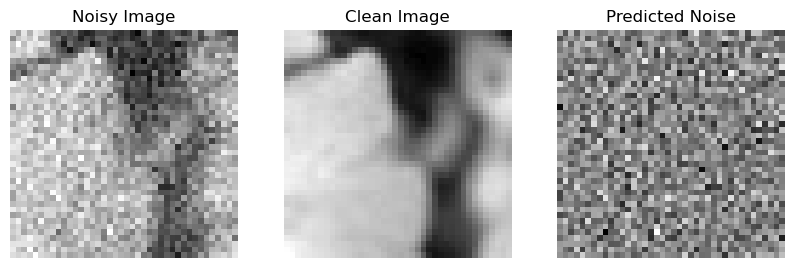

Batch 10/2500   | Loss: 0.001735
Batch 20/2500   | Loss: 0.001556
Batch 30/2500   | Loss: 0.001493
Batch 40/2500   | Loss: 0.001536
Batch 50/2500   | Loss: 0.001749
Batch 60/2500   | Loss: 0.001529
Batch 70/2500   | Loss: 0.001731
Batch 80/2500   | Loss: 0.001580
Batch 90/2500   | Loss: 0.001721
Batch 100/2500   | Loss: 0.001658
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_34_batch_100.pth
Batch 110/2500   | Loss: 0.001673
Batch 120/2500   | Loss: 0.001691
Batch 130/2500   | Loss: 0.001445
Batch 140/2500   | Loss: 0.001604
Batch 150/2500   | Loss: 0.001560
Batch 160/2500   | Loss: 0.001505
Batch 170/2500   | Loss: 0.001406
Batch 180/2500   | Loss: 0.001691
Batch 190/2500   | Loss: 0.001548
Batch 200/2500   | Loss: 0.001464
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_34_batch_200.pth
Batch 210/250

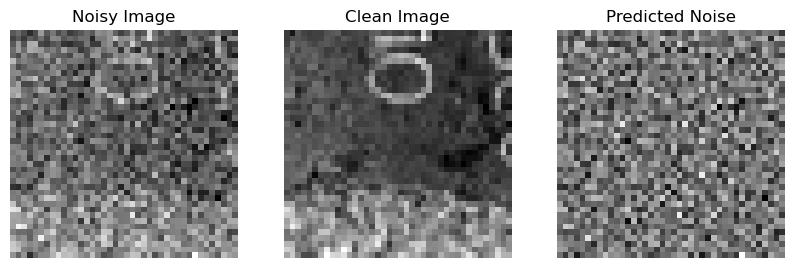

Batch 510/2500   | Loss: 0.001572
Batch 520/2500   | Loss: 0.001481
Batch 530/2500   | Loss: 0.001599
Batch 540/2500   | Loss: 0.001499
Batch 550/2500   | Loss: 0.001622
Batch 560/2500   | Loss: 0.001630
Batch 570/2500   | Loss: 0.001553
Batch 580/2500   | Loss: 0.001513
Batch 590/2500   | Loss: 0.001634
Batch 600/2500   | Loss: 0.001795
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_34_batch_600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_34_batch_300.pth
Batch 610/2500   | Loss: 0.001553
Batch 620/2500   | Loss: 0.001617
Batch 630/2500   | Loss: 0.001514
Batch 640/2500   | Loss: 0.001628
Batch 650/2500   | Loss: 0.001718
Batch 660/2500   | Loss: 0.001622
Batch 670/2500   | Loss: 0.001467
Batch 680/2500   | Loss: 0.001559
Batch 690/2500   | Loss: 0.001513
Batch 700/2500   | Loss: 0.00158

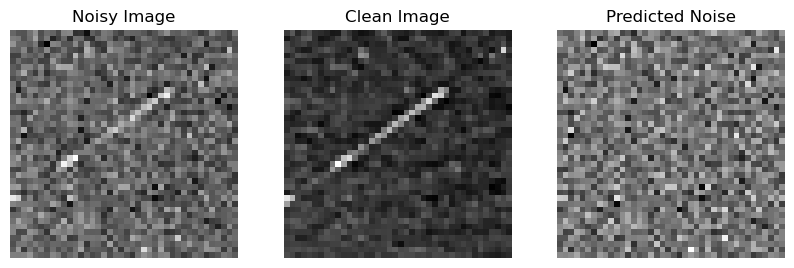

Batch 1010/2500   | Loss: 0.001480
Batch 1020/2500   | Loss: 0.001525
Batch 1030/2500   | Loss: 0.001673
Batch 1040/2500   | Loss: 0.001410
Batch 1050/2500   | Loss: 0.001491
Batch 1060/2500   | Loss: 0.001750
Batch 1070/2500   | Loss: 0.001490
Batch 1080/2500   | Loss: 0.001749
Batch 1090/2500   | Loss: 0.001577
Batch 1100/2500   | Loss: 0.001619
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_34_batch_1100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_34_batch_800.pth
Batch 1110/2500   | Loss: 0.001763
Batch 1120/2500   | Loss: 0.001492
Batch 1130/2500   | Loss: 0.001788
Batch 1140/2500   | Loss: 0.001529
Batch 1150/2500   | Loss: 0.001695
Batch 1160/2500   | Loss: 0.001627
Batch 1170/2500   | Loss: 0.001376
Batch 1180/2500   | Loss: 0.001471
Batch 1190/2500   | Loss: 0.001572
Batch 1200/2

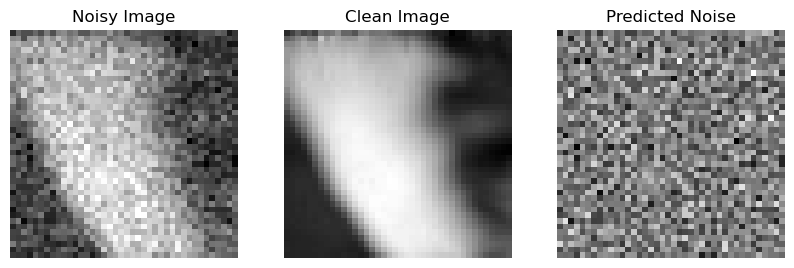

Batch 1510/2500   | Loss: 0.001481
Batch 1520/2500   | Loss: 0.001565
Batch 1530/2500   | Loss: 0.001627
Batch 1540/2500   | Loss: 0.001555
Batch 1550/2500   | Loss: 0.001476
Batch 1560/2500   | Loss: 0.001569
Batch 1570/2500   | Loss: 0.001841
Batch 1580/2500   | Loss: 0.001661
Batch 1590/2500   | Loss: 0.001605
Batch 1600/2500   | Loss: 0.001771
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_34_batch_1600.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_34_batch_1300.pth
Batch 1610/2500   | Loss: 0.001586
Batch 1620/2500   | Loss: 0.001585
Batch 1630/2500   | Loss: 0.001510
Batch 1640/2500   | Loss: 0.001462
Batch 1650/2500   | Loss: 0.001597
Batch 1660/2500   | Loss: 0.001558
Batch 1670/2500   | Loss: 0.001652
Batch 1680/2500   | Loss: 0.001829
Batch 1690/2500   | Loss: 0.001523
Batch 1700/

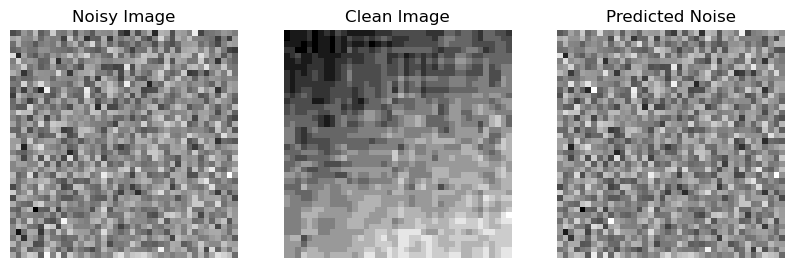

Batch 2010/2500   | Loss: 0.001584
Batch 2020/2500   | Loss: 0.001604
Batch 2030/2500   | Loss: 0.001474
Batch 2040/2500   | Loss: 0.001478
Batch 2050/2500   | Loss: 0.001566
Batch 2060/2500   | Loss: 0.001738
Batch 2070/2500   | Loss: 0.001489
Batch 2080/2500   | Loss: 0.001805
Batch 2090/2500   | Loss: 0.001657
Batch 2100/2500   | Loss: 0.001847
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_34_batch_2100.pth
Deleted old checkpoint: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_34_batch_1800.pth
Batch 2110/2500   | Loss: 0.001518
Batch 2120/2500   | Loss: 0.001585
Batch 2130/2500   | Loss: 0.001445
Batch 2140/2500   | Loss: 0.001686
Batch 2150/2500   | Loss: 0.001506
Batch 2160/2500   | Loss: 0.001445
Batch 2170/2500   | Loss: 0.001541
Batch 2180/2500   | Loss: 0.001654
Batch 2190/2500   | Loss: 0.001593
Batch 2200/

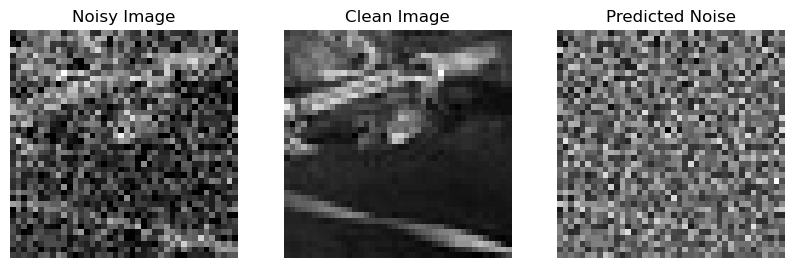

Batch 10/2500   | Loss: 0.001590
Batch 20/2500   | Loss: 0.001676
Batch 30/2500   | Loss: 0.001885
Batch 40/2500   | Loss: 0.001700
Batch 50/2500   | Loss: 0.001455
Batch 60/2500   | Loss: 0.001510
Batch 70/2500   | Loss: 0.001673
Batch 80/2500   | Loss: 0.001560
Batch 90/2500   | Loss: 0.001798
Batch 100/2500   | Loss: 0.001636
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_35_batch_100.pth
Batch 110/2500   | Loss: 0.001621
Batch 120/2500   | Loss: 0.001477
Batch 130/2500   | Loss: 0.001577
Batch 140/2500   | Loss: 0.001534
Batch 150/2500   | Loss: 0.001785
Batch 160/2500   | Loss: 0.001564
Batch 170/2500   | Loss: 0.001820
Batch 180/2500   | Loss: 0.001693
Batch 190/2500   | Loss: 0.001681
Batch 200/2500   | Loss: 0.001543
Checkpoint saved: /Users/User/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/NTU/Y3S2 Intern/Project 2/checkpoints/dncnn_epoch_35_batch_200.pth
Batch 210/250

In [ ]:
import time

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)

# Learning rate exponential decay
initial_lr = 0.1
final_lr = 0.0001
total_epochs = 50

def adjust_learning_rate(optimizer, epoch):
  lr = initial_lr * (final_lr / initial_lr) ** (epoch / total_epochs)
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return lr

# Apply He initialization
def weights_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

model.apply(weights_init)

epochs = 50

# Check for the latest checkpoint
checkpoint_files = glob.glob(os.path.join(save_dir, "dncnn_epoch_*.pth"))
if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)  # find the latest checkpoint file
    # ### EDITED: You can add `weights_only=True` if you only trust the weights,
    # but note that this will not load optimizer state or extra metadata.
    checkpoint = torch.load(latest_checkpoint)  # load the checkpoint

    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        # ### EDITED: Print missing keys before loading with strict=False
        loaded_state_dict = checkpoint['model_state_dict']
        model_state_dict = model.state_dict()
        missing_keys = [k for k in model_state_dict.keys() if k not in loaded_state_dict]
        if missing_keys:
            print("Warning: The following keys are missing from the checkpoint:")
            for k in missing_keys:
                print(k)
        # Load with strict=False to ignore missing keys (if that is acceptable)
        model.load_state_dict(loaded_state_dict, strict=False)  # ### EDITED: Use strict=False
        if 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            start_batch = checkpoint['batch_idx']
            print(f"Resuming training from {latest_checkpoint} (Epoch {start_epoch}), Batch {start_batch}")
        else:
            start_epoch, start_batch = 0, 0
            print("Resuming training with loaded weights, but optimizer state not found.")
    else:
        # Assume checkpoint is a simple state_dict (from an older format)
        model.load_state_dict(checkpoint, strict=False)  # ### EDITED: Use strict=False here as well
        start_epoch, start_batch = 0, 0
        print("Loaded a simple model state_dict, starting training from scratch.")
else:
    start_epoch, start_batch = 0, 0
    print("No checkpoints found, starting training from scratch.")


# Training
for epoch in range(start_epoch, epochs): # continue from last saved epoch
  epoch_start = time.time()
  running_loss = 0.0
  current_lr = adjust_learning_rate(optimizer, epoch) # update learning rate

  print(f"\n Epoch {epoch+1}/{epochs} - Learning Rate: {current_lr:.6f}")

  t0 = time.time() # Record start time of the epoch

  for batch_idx, (noisy_imgs, clean_imgs) in enumerate(dataloader):

    if epoch == start_epoch and batch_idx < start_batch:
      continue # skip already trained batches

    batch_t0 = time.time() # start time for this batch

    noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

    optimizer.zero_grad()
    # model predicts noise
    output = model(noisy_imgs)

    # compute loss between predicted noise and true noise
    loss = criterion(output, noisy_imgs-clean_imgs)

    loss.backward()

    # clip gradients to prevent explosion
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    running_loss += loss.item()

    batch_time = time.time() - batch_t0 # calculate time per batch

    # print progress for every 10 batches
    if batch_idx % 10 == 0:
      print(f"Batch {batch_idx}/{len(dataloader)}   | Loss: {loss.item():.6f}")

    # save checkpoint for every 100 batches
    if batch_idx % 100 == 0 and batch_idx > 0:
      save_checkpoint(epoch+1, batch_idx)
      cleanup_checkpoints(epoch+1, max_to_keep=3)

    # visualize sample images every 500 batches
    if batch_idx % 500 == 0:
      with torch.no_grad():
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title("Noisy Image")
        plt.axis("off")
        plt.imshow(noisy_imgs[0].cpu().squeeze(0).numpy(), cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title("Clean Image")
        plt.axis("off")
        plt.imshow(clean_imgs[0].cpu().squeeze(0).numpy(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Noise")
        plt.axis("off")
        plt.imshow(output[0].cpu().squeeze(0).numpy(), cmap='gray')
        plt.show()

  # print loss at the end of the epoch
  epoch_loss = running_loss / len(dataloader)
  epoch_time = time.time() - t0
  eta = epoch_time * (epochs - (epoch + 1)) # estimated time remaining
  print(f"Epoch {epoch+1} Completed - Loss: {epoch_loss:.6f} - Time: {epoch_time:.2f} sec - ETA {eta/3600:.2f} hours")

  # save final checkpoint after every epoch
  save_checkpoint(epoch+1, 0)

In [ ]:
# save the model

torch.save(model.state_dict(), "dncnn_s.pth")
print("Model saved as dncnn_s.pth")

Model saved as dncnn_s.pth


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install gdown

In [ ]:
! gdown https://github.com/cszn/DnCNN/archive/refs/heads/master.zip

Downloading...
From: https://github.com/cszn/DnCNN/archive/refs/heads/master.zip
To: /content/master.zip
151MB [00:05, 25.4MB/s]


In [ ]:
!unzip master.zip

Archive:  master.zip
e93b27812d3ff523a3a79d19e5e50d233d7a8d0a
replace DnCNN-master/Demo_FDnCNN_Color.m? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: DnCNN-master/Demo_FDnCNN_Color.m  
replace DnCNN-master/Demo_FDnCNN_Color_Clip.m? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: DnCNN-master/Demo_FDnCNN_Color_Clip.m  
  inflating: DnCNN-master/Demo_FDnCNN_Gray.m  
  inflating: DnCNN-master/Demo_FDnCNN_Gray_Clip.m  
  inflating: DnCNN-master/Demo_test_CDnCNN_Specific.m  
  inflating: DnCNN-master/Demo_test_DnCNN.m  
  inflating: DnCNN-master/Demo_test_DnCNN3.m  
  inflating: DnCNN-master/Demo_test_DnCNN_C.m  
  inflating: DnCNN-master/README.md  
  inflating: DnCNN-master/TrainingCodes/DnCNN_TrainingCodes_DagNN_v1.1/Demo_Test_DnCNN_DAG.m  
  inflating: DnCNN-master/TrainingCodes/DnCNN_TrainingCodes_DagNN_v1.1/Demo_Train_DnCNN_DAG.m  
  inflating: DnCNN-master/TrainingCodes/DnCNN_TrainingCodes_DagNN_v1.1/DnCNN_Init.m  
  inflating: DnCNN-master/TrainingCodes/DnCNN_TrainingCod

In [ ]:
!ls DnCNN-master/testsets/BSD68

test001.png  test011.png  test021.png  test031.png  test041.png  test051.png  test061.png
test002.png  test012.png  test022.png  test032.png  test042.png  test052.png  test062.png
test003.png  test013.png  test023.png  test033.png  test043.png  test053.png  test063.png
test004.png  test014.png  test024.png  test034.png  test044.png  test054.png  test064.png
test005.png  test015.png  test025.png  test035.png  test045.png  test055.png  test065.png
test006.png  test016.png  test026.png  test036.png  test046.png  test056.png  test066.png
test007.png  test017.png  test027.png  test037.png  test047.png  test057.png  test067.png
test008.png  test018.png  test028.png  test038.png  test048.png  test058.png  test068.png
test009.png  test019.png  test029.png  test039.png  test049.png  test059.png
test010.png  test020.png  test030.png  test040.png  test050.png  test060.png


In [ ]:
!ls DnCNN-master/testsets/Set12

01.png	02.png	03.png	04.png	05.png	06.png	07.png	08.png	09.png	10.png	11.png	12.png


In [ ]:
!mkdir -p /content/test_dataset/
!mkdir -p /content/test_dataset2/

In [ ]:
!mv /content/DnCNN-master/testsets/BSD68 /content/test_dataset/

mv: cannot move '/content/DnCNN-master/testsets/BSD68' to '/content/test_dataset/BSD68': Directory not empty


In [ ]:
!mv /content/DnCNN-master/testsets/Set12 /content/test_dataset2/

mv: cannot move '/content/DnCNN-master/testsets/Set12' to '/content/test_dataset2/Set12': Directory not empty


In [ ]:
# Test dataset class

class TestDataset(Dataset):
  def __init__(self, image_dir, sigma=25):
    self.image_paths = glob.glob(os.path.join(image_dir, "*.png")) # change if jpg format
    self.sigma = sigma / 255.0

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    # load and preprocess image
    img = cv2.imread(self.image_paths[index], cv2.IMREAD_GRAYSCALE)
    img = img_as_float(img) # convert pixel values to [0,1]

    img_tensor = torch.from_numpy(img).float().unsqueeze(0) # convert to tensor, add channel dim (1,H,W)

    # add Gaussian noise
    noise = torch.randn_like(img_tensor) * self.sigma
    noisy_img = img_tensor + noise
    noisy_img = torch.clamp(noisy_img, 0, 1)

    return noisy_img, img_tensor # noisy image, clean image

In [ ]:
# Load the trained model

model = DnCNN(channels=1, num_layers=17)
model.load_state_dict(torch.load("dncnn_s.pth"))
model = model.to(device)
model.eval()

# Set dataset paths
bsd68_path = "/content/test_dataset/BSD68"
set12_path = "/content/test_dataset2/Set12"

print(os.listdir(bsd68_path))
print(os.listdir(set12_path))

# Load test datasets
bsd68_loader = DataLoader(TestDataset(bsd68_path), batch_size=1, shuffle=False)
set12_loader = DataLoader(TestDataset(set12_path), batch_size=1, shuffle=False)

def evaluate_model(dataloader, dataset_name):
  psnr_values = []
  ssim_values = []

  for noisy_imgs, clean_imgs in dataloader:
    noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

    with torch.no_grad():
      denoised_imgs = model(noisy_imgs).clamp(0,1)

    for i in range(noisy_imgs.size(0)):
      clean_np = clean_imgs[i].cpu().squeeze(0).numpy()
      denoised_np = denoised_imgs[i].cpu().squeeze(0).numpy()

      # compute PSNR and SSIM
      psnr_values.append(psnr(clean_np, denoised_np, data_range=1))
      ssim_values.append(ssim(clean_np, denoised_np, data_range=1, channel_axis=None))

  avg_psnr = np.mean(psnr_values)
  avg_ssim = np.mean(ssim_values)

  print(f"{dataset_name} Evaluation: Average PSNR: {avg_psnr:.4f} dB, Average SSIM: {avg_ssim:.4f}")

# Evaluate the model on the test datasets
evaluate_model(bsd68_loader, "BSD68")
evaluate_model(set12_loader, "Set12")

['test018.png', 'test015.png', 'test006.png', 'test046.png', 'test059.png', 'test021.png', 'test030.png', 'test012.png', 'test065.png', 'test010.png', 'test013.png', 'test003.png', 'test001.png', 'test004.png', 'test057.png', 'test024.png', 'test037.png', 'test062.png', 'test040.png', 'test025.png', 'test049.png', 'test034.png', 'test002.png', 'test033.png', 'test019.png', 'test061.png', 'test014.png', 'test048.png', 'test068.png', 'test054.png', 'test032.png', 'test067.png', 'test023.png', 'test027.png', 'test026.png', 'test045.png', 'test011.png', 'test009.png', 'test028.png', 'test058.png', 'test029.png', 'test038.png', 'test050.png', 'test043.png', 'test022.png', 'test042.png', 'test064.png', 'test016.png', 'test008.png', 'test053.png', 'test063.png', 'test055.png', 'test017.png', 'test041.png', 'test060.png', 'test066.png', 'test020.png', 'test052.png', 'test007.png', 'test036.png', 'test047.png', 'test039.png', 'test056.png', 'test035.png', 'test031.png', 'test051.png', 'test005.

<ipython-input-89-ca97227c8711>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dncnn_s.pth"))


BSD68 Evaluation: Average PSNR: 20.7671 dB, Average SSIM: 0.4174
Set12 Evaluation: Average PSNR: 20.5818 dB, Average SSIM: 0.3945
